In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from prophet import Prophet
import logging

In [3]:
data = pd.read_csv('../data/regional_univariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

# def log_transform(x):
#     return np.log(x) if x > 0 else 0

def prepare_and_split_data(data, test_size = 0.15):
    data = data[['date', 'new_confirmed']].copy() 
    data = data.rename(columns = {'date': 'ds', 'new_confirmed':'y'})
    data = data.sort_values(by = 'ds')
    # data['y'] = data['y'].apply(lambda x: log_transform(x))
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))

enc_train.head()

Length enc train:  822
Length enc test:  146


ds    y
0  2020-01-22  0.0
1  2020-01-23  0.0
2  2020-01-24  1.0
3  2020-01-25  0.0
4  2020-01-26  0.0

In [55]:
def search_prophet(train, test, changepoints = np.logspace(-3, -1, num = 5), seasonalities = np.array([10, 100, 500]), n_changepoints_vals = np.array([15, 25, 50]), transformation = None, figsize = (10,6)):
    models = {}

    for changepoint, seasonality, n_changepoint in itertools.product(changepoints, seasonalities, n_changepoints_vals):
        model = Prophet(changepoint_prior_scale=changepoint, seasonality_prior_scale= seasonality, n_changepoints= n_changepoint)
        model.fit(train)

        test_forecast = model.predict(test)

        test['ds'] = pd.to_datetime(test['ds'])
        test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

        min_test_date = test['ds'].min()
        max_test_date = test['ds'].max()
        forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
        y_actual = test['y'].values
        y_pred = forecast_filtered['yhat'].values

        # mae = mean_absolute_error(y_actual, y_pred) 
        # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])
        
        models[changepoint] = (model, mase, test_forecast, changepoint, seasonality, n_changepoint)

    best_changepoint = min(models, key = lambda k: models[k][1])
    model, best_mase, test_forecast, changepoint, seasonality, n_changepoint = models[best_changepoint] 
    print('changepoint_prior_scale: ', changepoint)
    print('seasonality_prior_scale: ', seasonality)
    print('n_changepoints: ', n_changepoint)

    train_forecast = model.predict(train)

    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)

    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
    for i in range(len(forecast_filtered['yhat'])):
        if forecast_filtered['yhat'][i] < 0:
            forecast_filtered['yhat'][i] = 0


    plt.figure(figsize = figsize)
    plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases', color='red')
    # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)

    # Calculate MASE
    # naive = y_actual[:-1]
    # naive_mae = mean_absolute_error(y_actual[1:], naive)
    # mase = mae / naive_mae
    mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")
    # print(f"New MASE: {new_mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

In [72]:
def check_hyperparams(train, test, changepoints = np.logspace(-3.5, .5, num = 50), seasonalities = np.logspace(-2, 4, num = 50), \
                      n_changepoints_vals = np.logspace(1, 3, num = 50), param = 'changepoint_prior_scale', metric = 'MASE'):
    param_vals = []
    mae_values = []
    rmse_values = []
    mase_values = []

    if param == 'changepoint_prior_scale':
        for cps in changepoints:
            m = Prophet(changepoint_prior_scale=cps)
            m.fit(train)
            
            future = m.make_future_dataframe(periods=len(test), freq='D') 
            forecast = m.predict(future)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(cps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'seasonality_prior_scale':
        for sps in seasonalities:
            m = Prophet(seasonality_prior_scale=sps)
            m.fit(train)
            
            future = m.make_future_dataframe(periods=len(test), freq='D') 
            forecast = m.predict(future)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(sps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'n_changepoints':
        for ncps in n_changepoints_vals:
            m = Prophet(n_changepoints = int(ncps))
            m.fit(train)
            
            future = m.make_future_dataframe(periods=len(test), freq='D') 
            forecast = m.predict(future)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(ncps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)

    plt.figure(figsize=(10, 6))
    if metric == 'MAE':
        plt.plot(param_vals, mae_values, marker='o')
        plt.ylabel('MAE')
        sorted_indexes = np.argsort(mae_values)
        print("Lowest 5 MAEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MAE: {mae_values[index]}")
    elif metric == 'RMSE':
        plt.plot(param_vals, rmse_values, marker='o')
        plt.ylabel('RMSE')
        sorted_indexes = np.argsort(rmse_values)
        print("Lowest 5 RMSEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, RMSE: {rmse_values[index]}")
    elif metric == 'MASE':
        plt.plot(param_vals, mase_values, marker='o')
        plt.ylabel('MASE')
        sorted_indexes = np.argsort(mase_values)
        print("Lowest 5 MASEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MASE: {mase_values[index]}")
    plt.title('param vs metric')
    plt.xlabel('param')
    plt.xscale('log')
    plt.show()



# ENC

17:45:49 - cmdstanpy - INFO - Chain [1] start processing
17:45:49 - cmdstanpy - INFO - Chain [1] done processing
17:45:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:49 - cmdstanpy - INFO - Chain [1] start processing
17:45:51 - cmdstanpy - INFO - Chain [1] done processing
17:45:51 - cmdstanpy - INFO - Chain [1] start processing
17:45:52 - cmdstanpy - INFO - Chain [1] done processing
17:45:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:52 - cmdstanpy - INFO - Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing
17:45:53 - cmdstanpy - INFO - Chain [1] start processing
17:45:53 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 -

Lowest 5 MASEs and params:
param: 0.08891593339164633, MASE: 0.948210048405015
param: 0.0025001103826179307, MASE: 0.990825218302499
param: 0.0020716983998953077, MASE: 0.9950483956474538
param: 0.0017166979066078603, MASE: 0.9976447562186169
param: 0.0030171148105292956, MASE: 1.0051913123160483


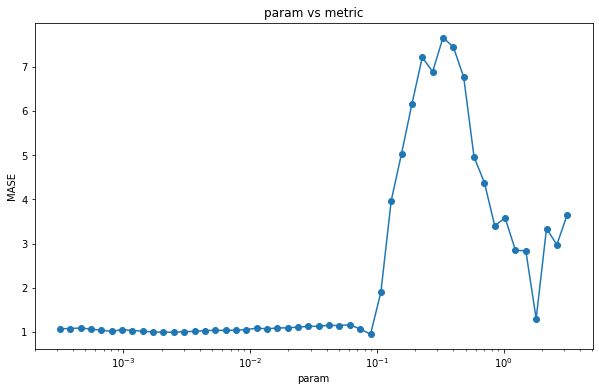

In [21]:
check_hyperparams(enc_train, enc_test)

17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 5689.866029018293, MASE: 1.1410292243582072
param: 0.29470517025518095, MASE: 1.1411147890631665
param: 82.86427728546842, MASE: 1.1417001771017774
param: 3.727593720314938, MASE: 1.1420176316201733
param: 10000.0, MASE: 1.1420276162000442


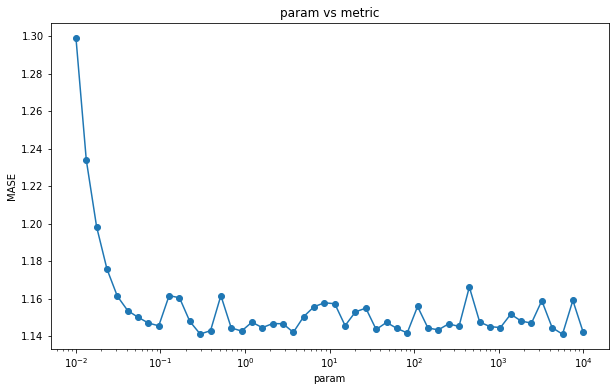

In [25]:
check_hyperparams(enc_train, enc_test, param = 'seasonality_prior_scale')

17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:42 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - INFO - Chain [1] start processing
17:48:43 - cmdstanpy - INFO - Chain [1] done processing
17:48:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 1.0, MASE: 1.080319408803771
param: 1.1513953993264474, MASE: 1.080319408803771
param: 1.3257113655901092, MASE: 1.080319408803771
param: 1.5264179671752334, MASE: 1.080319408803771
param: 1.7575106248547918, MASE: 1.080319408803771


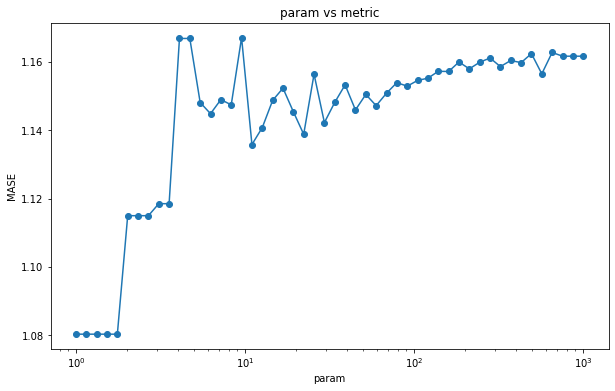

In [26]:
check_hyperparams(enc_train, enc_test, param = 'n_changepoints')

18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
18:24:50 - cmdstanpy - INFO - Chain [1] start process

changepoint_prior_scale:  0.08892
seasonality_prior_scale:  10000
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

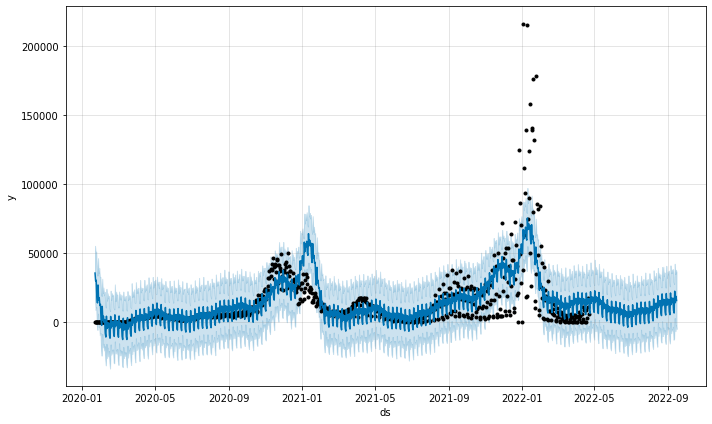

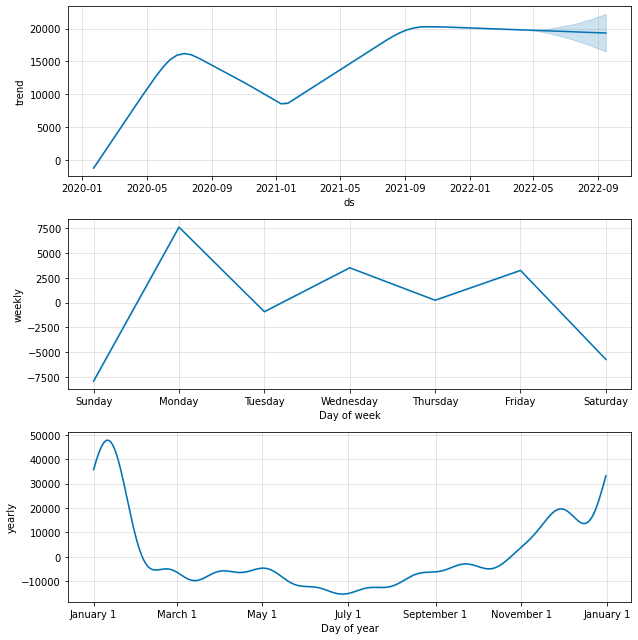

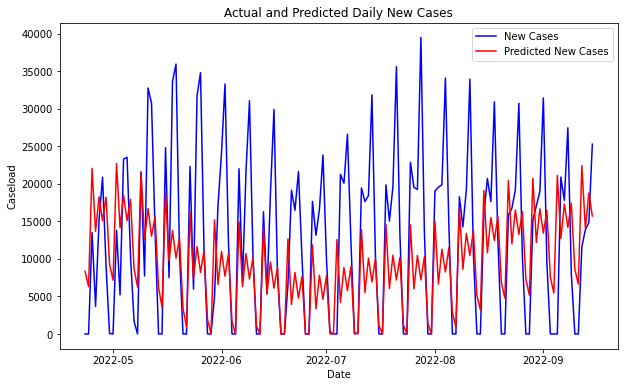

MAE: 7605.149837513869
RMSE: 10488.184231953413
MSE: 110002008.48339623
MASE: 0.9589551610992114


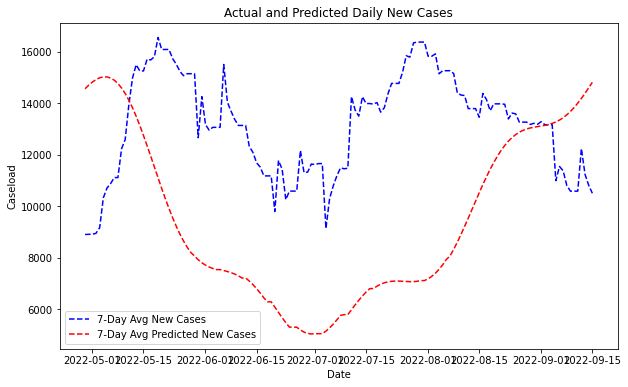

7-Day Avg MAE: 4920.525005026591
7-Day Avg RMSE: 5481.513304262495
7-Day Avg MSE: 30046988.104806732
7-Day Avg MASE: 11.999099176172807
7-Day Avg MAPE: 0.37524288081697815


In [58]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test, changepoints = [.002072, .0025, .003017, .08892, .001717], seasonalities= [5689, .295, 82.9, 3.728, 10000], n_changepoints_vals= [1, 3, 10, 20, 50])

18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing
18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing
18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing
18:25:30 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0031622776601683794
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

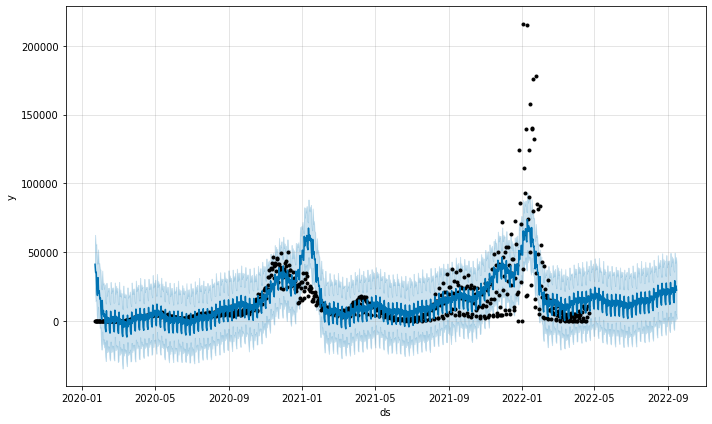

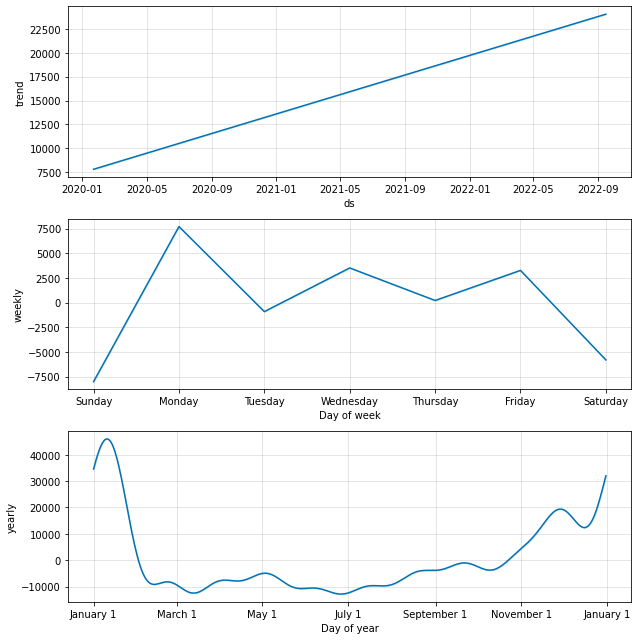

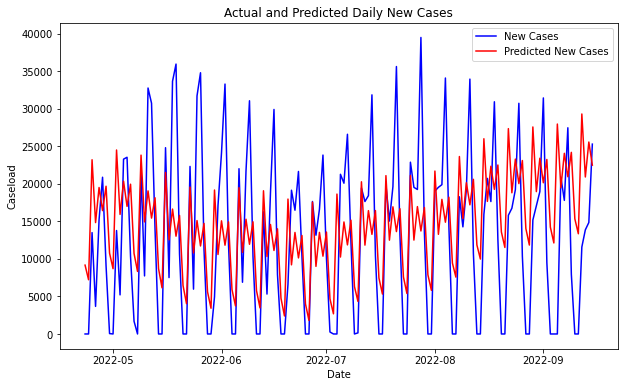

MAE: 8126.831563041257
RMSE: 9923.89440260302
MSE: 98483680.11401555
MASE: 1.024735506501212


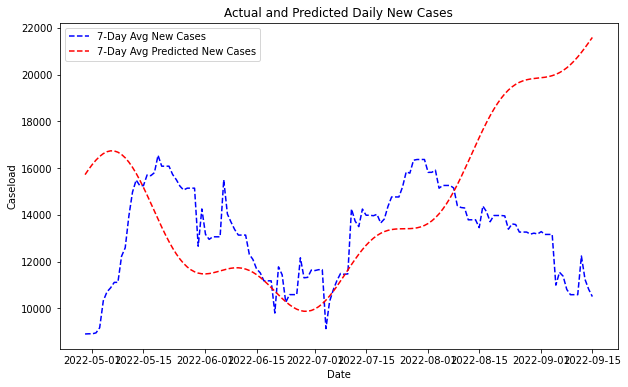

7-Day Avg MAE: 3150.496975612136
7-Day Avg RMSE: 4212.375031864954
7-Day Avg MSE: 17744103.409079272
7-Day Avg MASE: 7.682742314282418
7-Day Avg MAPE: 0.25482631330402006


In [59]:
model, models, forecast_midatl, fig1, fig2 = search_prophet(enc_train, enc_test)

# ESC

17:53:20 - cmdstanpy - INFO - Chain [1] start processing
17:53:20 - cmdstanpy - INFO - Chain [1] done processing
17:53:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:20 - cmdstanpy - INFO - Chain [1] start processing
17:53:22 - cmdstanpy - INFO - Chain [1] done processing
17:53:22 - cmdstanpy - INFO - Chain [1] start processing
17:53:22 - cmdstanpy - INFO - Chain [1] done processing
17:53:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:22 - cmdstanpy - INFO - Chain [1] start processing
17:53:24 - cmdstanpy - INFO - Chain [1] done processing
17:53:24 - cmdstanpy - INFO - Chain [1] start processing
17:53:24 - cmdstanpy - INFO - Chain [1] done processing
17:53:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.08891593339164633, MASE: 1.3100137611100193
param: 0.0736795455966163, MASE: 1.4124765182119874
param: 0.0005557736586486875, MASE: 1.439182859734699
param: 0.0009767781100894892, MASE: 1.480144247894735
param: 0.0017166979066078603, MASE: 1.4891678145118368


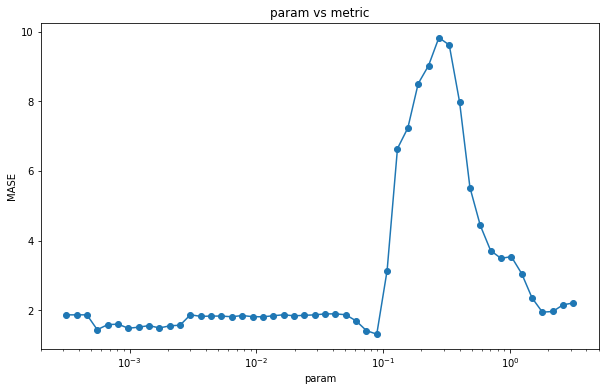

In [33]:
check_hyperparams(esc_train, esc_test)

17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 8.68511373751352, MASE: 1.7794590964215855
param: 0.09540954763499938, MASE: 1.7905222862001826
param: 6.551285568595509, MASE: 1.7930776191751014
param: 0.07196856730011521, MASE: 1.7936627159454486
param: 0.040949150623804255, MASE: 1.7967024514850836


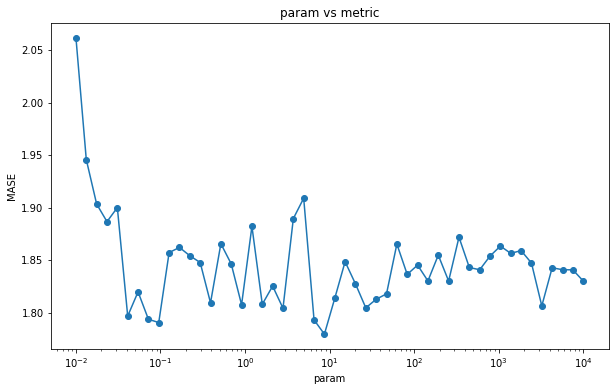

In [34]:
check_hyperparams(esc_train, esc_test, param = 'seasonality_prior_scale')

17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
17:55:50 - cmdstanpy - INFO - Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
17:55:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:50 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 68.66488450043002, MASE: 1.7921686067016764
param: 9.54095476349994, MASE: 1.7926835064498978
param: 6.250551925273973, MASE: 1.794970134294055
param: 29.4705170255181, MASE: 1.802333467686417
param: 25.59547922699536, MASE: 1.811362870718893


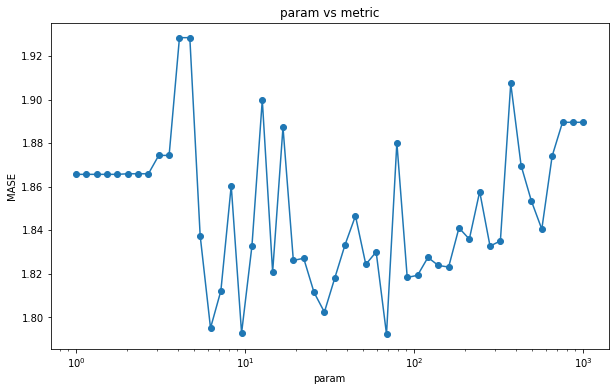

In [35]:
check_hyperparams(esc_train, esc_test, param = 'n_changepoints')

18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start process

changepoint_prior_scale:  0.089
seasonality_prior_scale:  0.04095
n_changepoints:  25


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

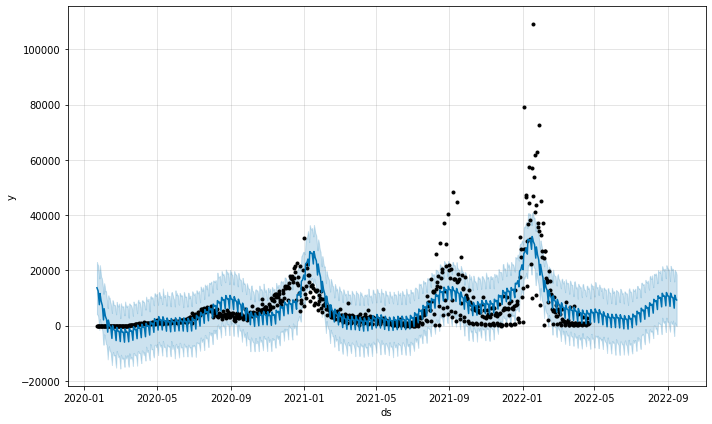

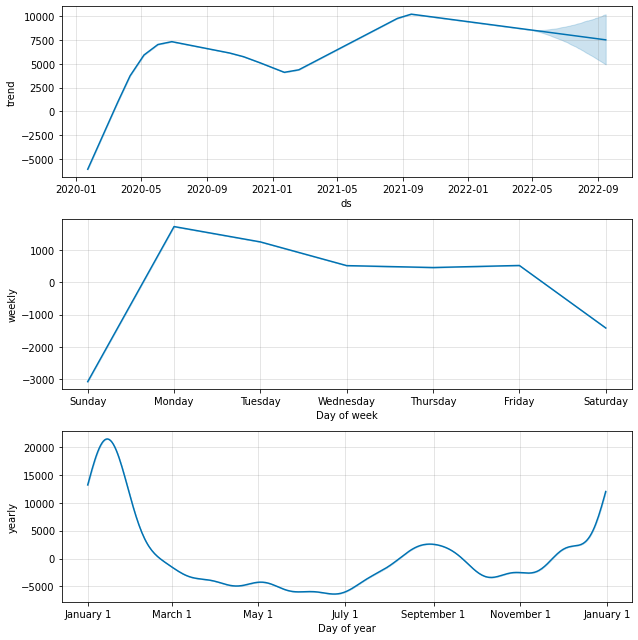

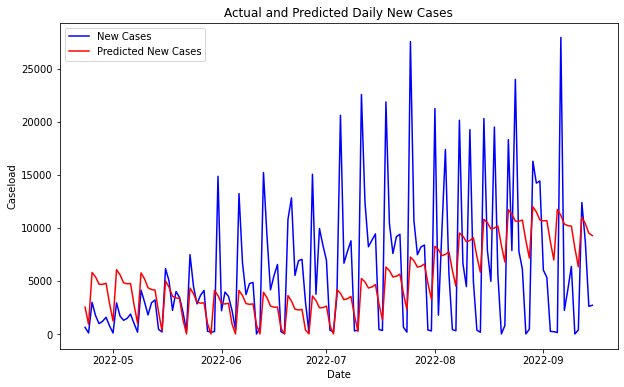

MAE: 4294.571105367072
RMSE: 5820.712809924551
MSE: 33880697.615619764
MASE: 1.296017042871319


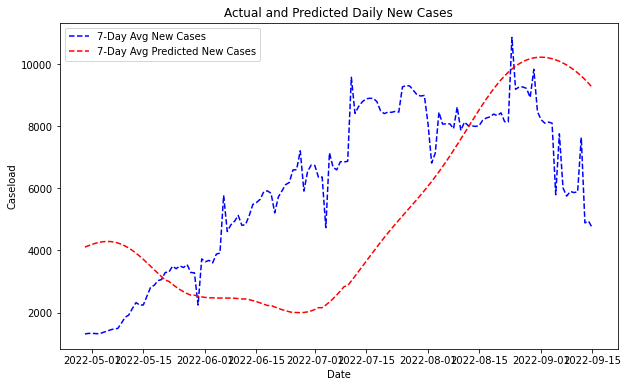

7-Day Avg MAE: 2535.1779732160117
7-Day Avg RMSE: 2980.509496343342
7-Day Avg MSE: 8883436.857792843
7-Day Avg MASE: 6.598112753733303
7-Day Avg MAPE: 0.5293432068596916


In [43]:
model, models, forecast_esc, fig1, fig2 = search_prophet(esc_train, esc_test, changepoints = [.089, .074, .00056, .000978, .001717], seasonalities= [8.69, .095, 6.551, 0.0719, 0.04095], n_changepoints_vals= [10, 69, 6, 29, 25])

18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:05 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:06 - cmdstanpy - INFO - Chain [1] done processing
18:23:06 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
18:23:07 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
18:23:07 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

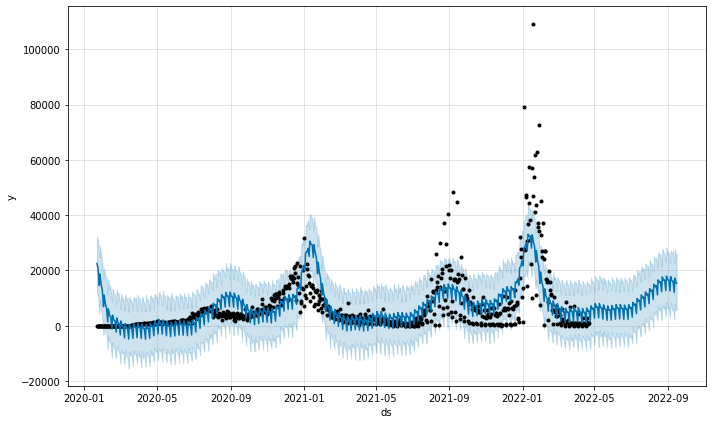

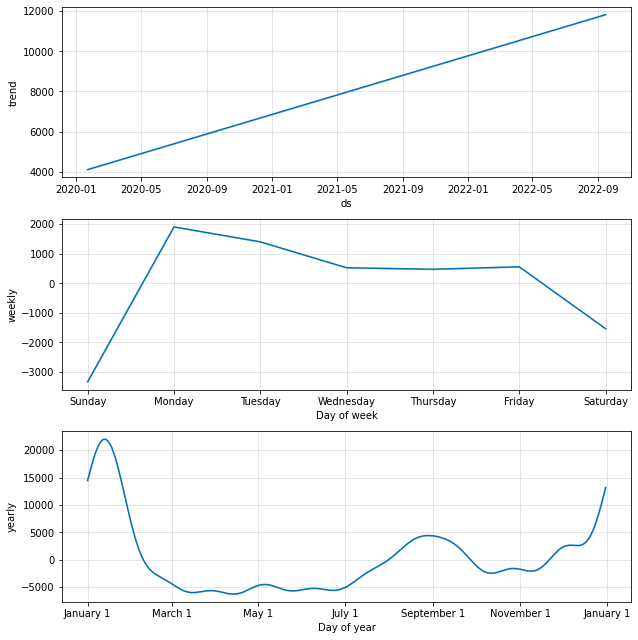

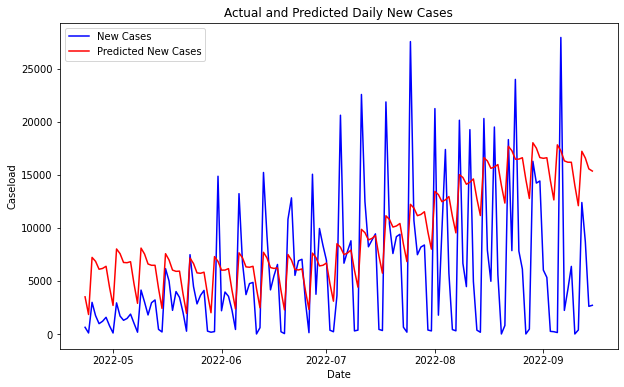

MAE: 5356.30041890682
RMSE: 6763.081292621003
MSE: 45739268.570600174
MASE: 1.6164260549712515


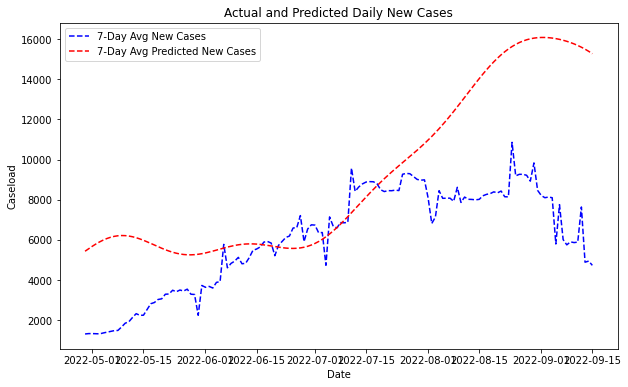

7-Day Avg MAE: 3354.0832131491215
7-Day Avg RMSE: 4469.359689942342
7-Day Avg MSE: 19975176.038081508
7-Day Avg MASE: 8.729414447257955
7-Day Avg MAPE: 0.7708268901979831


In [57]:
model, models, forecast_midatl, fig1, fig2 = search_prophet(esc_train, esc_test)

# MIDATL

18:27:49 - cmdstanpy - INFO - Chain [1] start processing
18:27:49 - cmdstanpy - INFO - Chain [1] done processing
18:27:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:27:49 - cmdstanpy - INFO - Chain [1] start processing
18:27:57 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing
18:27:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:00 - cmdstanpy - INFO - Chain [1] start processing
18:28:00 - cmdstanpy - INFO - Chain [1] done processing
18:28:00 - cmdstanpy - INFO - Chain [1] start process

Lowest 5 MASEs and params:
param: 0.016378937069540637, MASE: 2.9847472143149285
param: 0.00639915233634926, MASE: 2.99290286752566
param: 0.01357228782971653, MASE: 2.9955658045382756
param: 0.011246578221198195, MASE: 3.0044306016335534
param: 0.019765980717016327, MASE: 3.0088401133312916


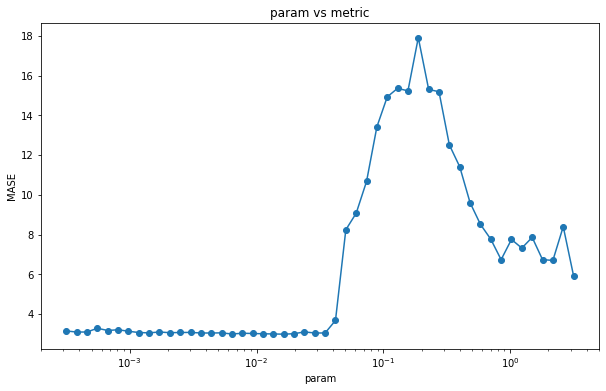

In [60]:
check_hyperparams(midatl_train, midatl_test)

18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:43 - cmdstanpy - INFO - Chain [1] done processing
18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
18:28:45 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
18:28:45 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.01, MASE: 2.842097101340554
param: 0.017575106248547922, MASE: 3.1518389172445094
param: 0.013257113655901088, MASE: 4.211574495856108
param: 6.551285568595509, MASE: 5.48429450068789
param: 0.517947467923121, MASE: 5.532429528205149


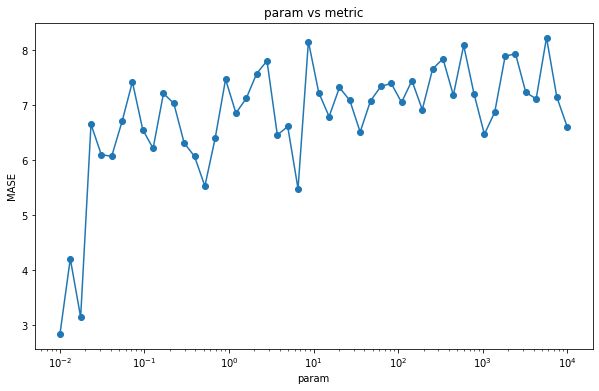

In [61]:
check_hyperparams(midatl_train, midatl_test, param = 'seasonality_prior_scale')

18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 1.0, MASE: 2.849947180155608
param: 1.1513953993264474, MASE: 2.849947180155608
param: 1.3257113655901092, MASE: 2.849947180155608
param: 1.5264179671752334, MASE: 2.849947180155608
param: 1.7575106248547918, MASE: 2.849947180155608


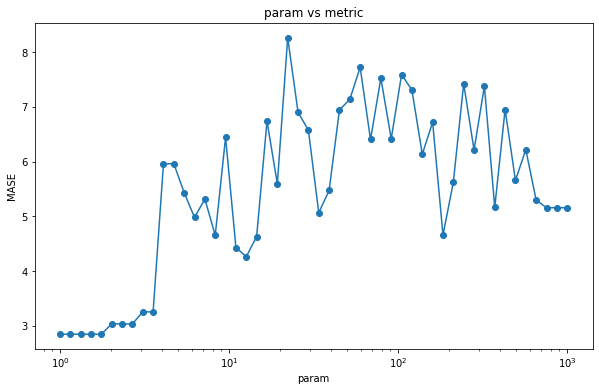

In [62]:
check_hyperparams(midatl_train, midatl_test, param = 'n_changepoints')

18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 -

changepoint_prior_scale:  0.014
seasonality_prior_scale:  6.52
n_changepoints:  100


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

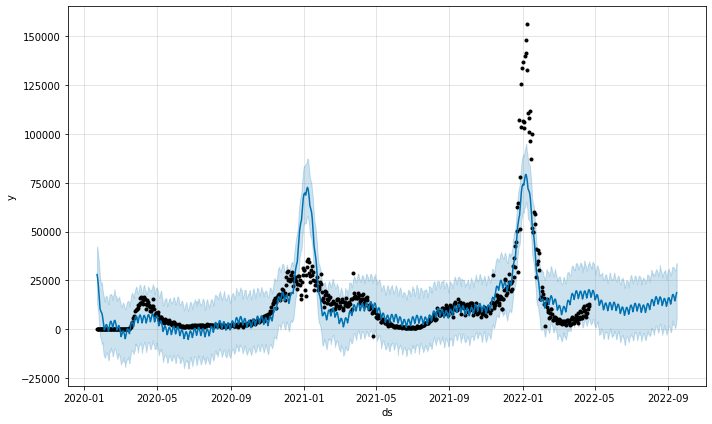

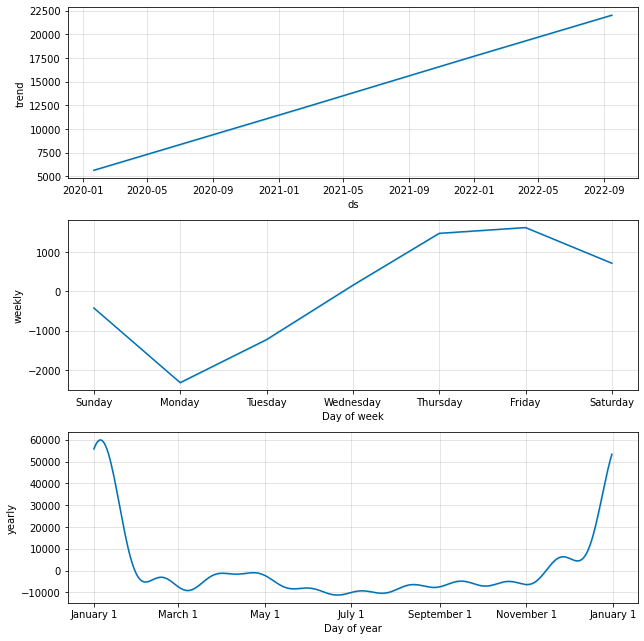

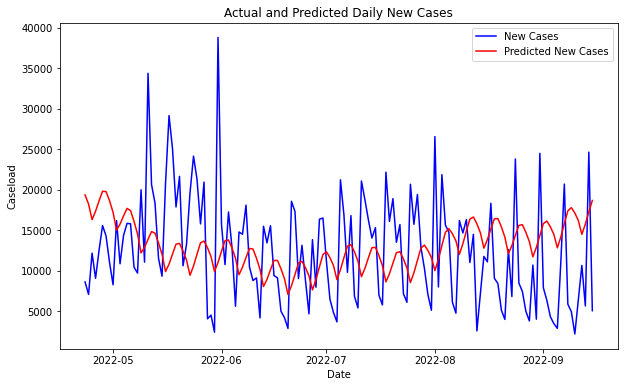

MAE: 6324.988691495519
RMSE: 7641.62376257351
MSE: 58394413.72872814
MASE: 2.983144158085148


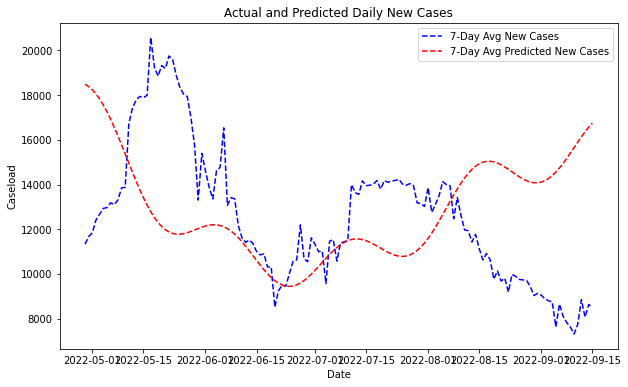

7-Day Avg MAE: 3321.506878028921
7-Day Avg RMSE: 4080.730432860708
7-Day Avg MSE: 16652360.865675539
7-Day Avg MASE: 6.13996854821142
7-Day Avg MAPE: 0.28569039274280694


In [63]:
model, models, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test, changepoints=[.016, .0064, .014, .011, .20], seasonalities=[.01, .018, .013, 6.55, 6.52], n_changepoints_vals=[1, 2, 3, 10, 15, 100])

18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.01
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

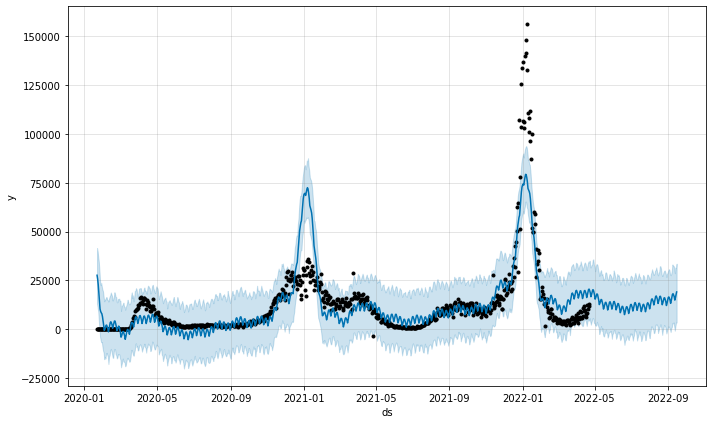

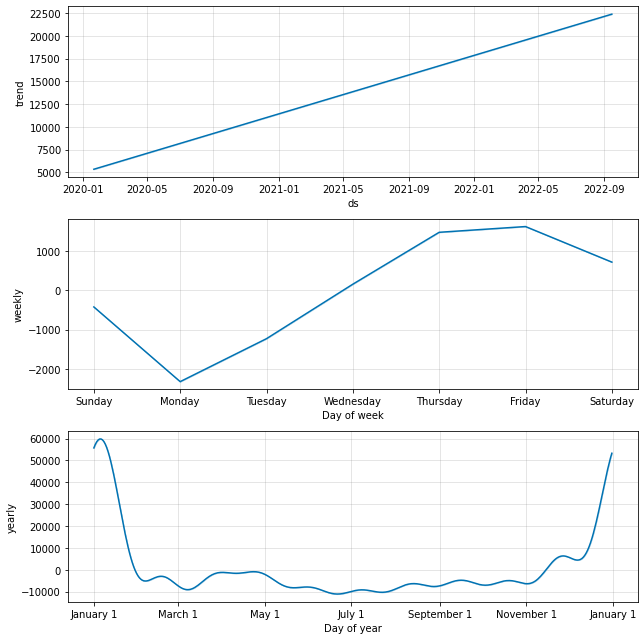

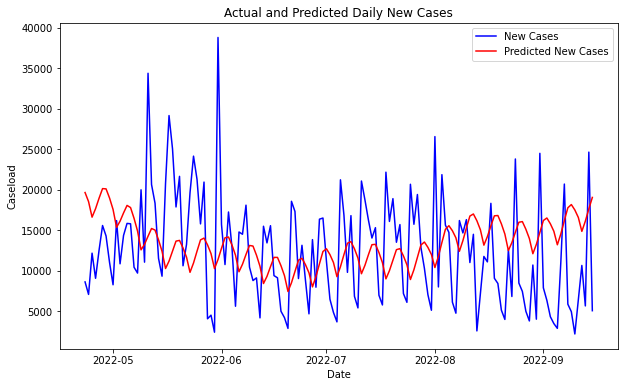

MAE: 6391.934643213328
RMSE: 7676.775310413098
MSE: 58932879.166568115
MASE: 3.014718827150242


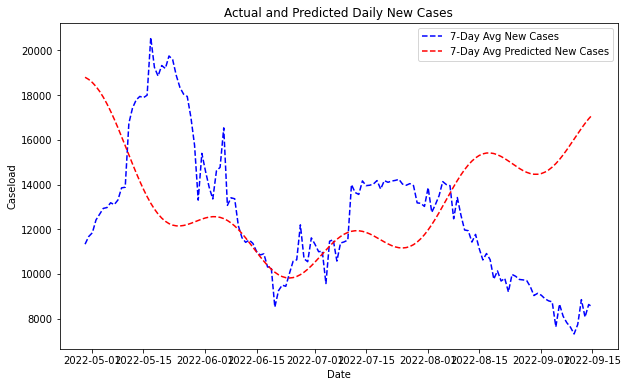

7-Day Avg MAE: 3269.519862815667
7-Day Avg RMSE: 4119.371703216847
7-Day Avg MSE: 16969223.229263663
7-Day Avg MASE: 6.043867998055645
7-Day Avg MAPE: 0.2861880970128831


In [64]:
model, models, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test)

# MOUNTAIN

18:18:50 - cmdstanpy - INFO - Chain [1] start processing
18:18:50 - cmdstanpy - INFO - Chain [1] done processing
18:18:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:18:50 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing
18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:52 - cmdstanpy - INFO - Chain [1] done processing
18:18:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:18:52 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing
18:18:54 - cmdstanpy - INFO - Chain [1] start processing
18:18:54 - cmdstanpy - INFO - Chain [1] done processing
18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:55 - cmdstanpy - INFO - Chain [1] done processing
18:18:55 -

Lowest 5 MASEs and params:
param: 0.08891593339164633, MASE: 1.413417676303127
param: 0.0736795455966163, MASE: 1.7586385745353281
param: 0.001422529313485369, MASE: 1.8617031858444288
param: 0.0008094001216083124, MASE: 1.8644243224450894
param: 0.0025001103826179307, MASE: 1.9024727892489297


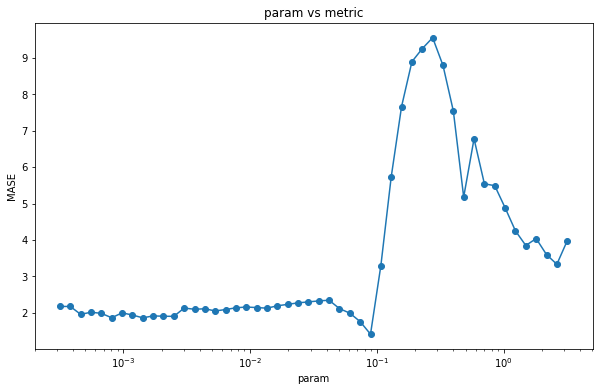

In [51]:
check_hyperparams(mount_train, mount_test)

18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing
18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:00 - cmdstanpy - INFO - Chain [1] done processing
18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
18:20:01 - cmdstanpy - INFO - Chain [1] start processing
18:20:01 - cmdstanpy - INFO - Chain [1] done processing
18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:03 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.12648552168552957, MASE: 2.100977815742011
param: 0.6866488450043002, MASE: 2.1048276509992423
param: 193.06977288832496, MASE: 2.110725772713033
param: 20.235896477251575, MASE: 2.1115657936221828
param: 0.517947467923121, MASE: 2.118086736633906


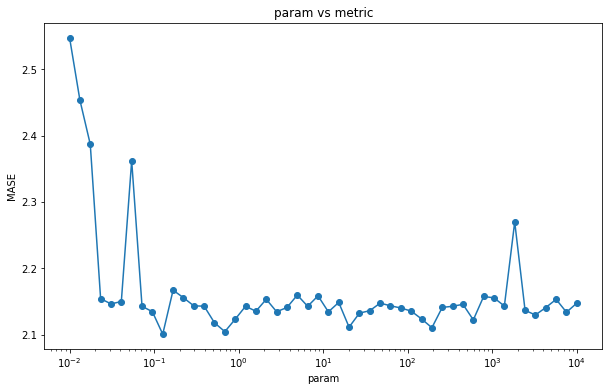

In [54]:
check_hyperparams(mount_train, mount_test, param = 'seasonality_prior_scale')

06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:32 - cmdstanpy - INFO - Chain [1] start processing
06:19:32 - cmdstanpy - INFO - Chain [1] done processing
06:19:32 - cmdstanpy - INFO - Chain [1] start processing
06:19:32 - cmdstanpy - INFO - Chain [1] done processing
06:19:32 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1] done processing
06:19:35 - cmdstanpy - INFO - Chain [1] start processing
06:19:35 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 33.93221771895328, MASE: 2.1162474921341907
param: 14.563484775012437, MASE: 2.1237840909112387
param: 12.648552168552959, MASE: 2.1310153480232636
param: 44.98432668969446, MASE: 2.132120240804814
param: 9.54095476349994, MASE: 2.1326464701436767


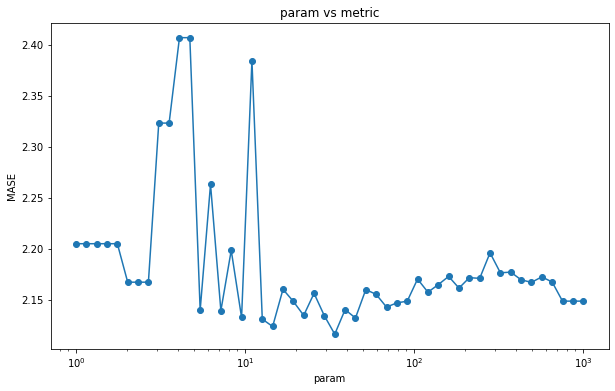

In [65]:
check_hyperparams(mount_train, mount_test, param= 'n_changepoints')

06:20:38 - cmdstanpy - INFO - Chain [1] start processing
06:20:39 - cmdstanpy - INFO - Chain [1] done processing
06:20:39 - cmdstanpy - INFO - Chain [1] start processing
06:20:39 - cmdstanpy - INFO - Chain [1] done processing
06:20:39 - cmdstanpy - INFO - Chain [1] start processing
06:20:40 - cmdstanpy - INFO - Chain [1] done processing
06:20:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:20:40 - cmdstanpy - INFO - Chain [1] start processing
06:20:41 - cmdstanpy - INFO - Chain [1] done processing
06:20:41 - cmdstanpy - INFO - Chain [1] start processing
06:20:41 - cmdstanpy - INFO - Chain [1] done processing
06:20:41 - cmdstanpy - INFO - Chain [1] start processing
06:20:41 - cmdstanpy - INFO - Chain [1] done processing
06:20:42 - cmdstanpy - INFO - Chain [1] start processing
06:20:42 - cmdstanpy - INFO - Chain [1] done processing
06:20:42 - cmdstanpy - INFO - Chain [1] start process

changepoint_prior_scale:  0.089
seasonality_prior_scale:  0.52
n_changepoints:  45


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

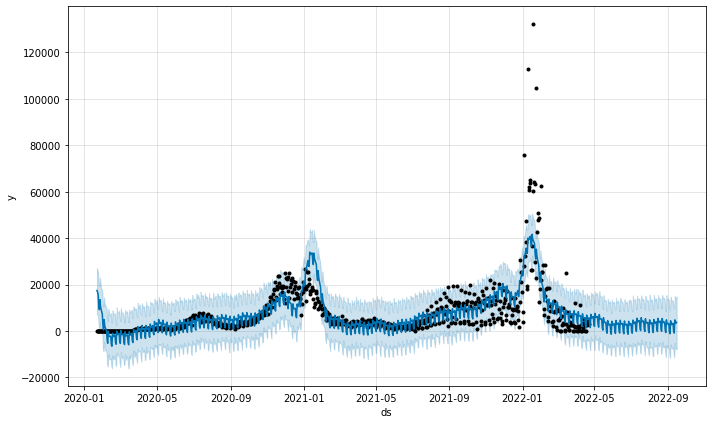

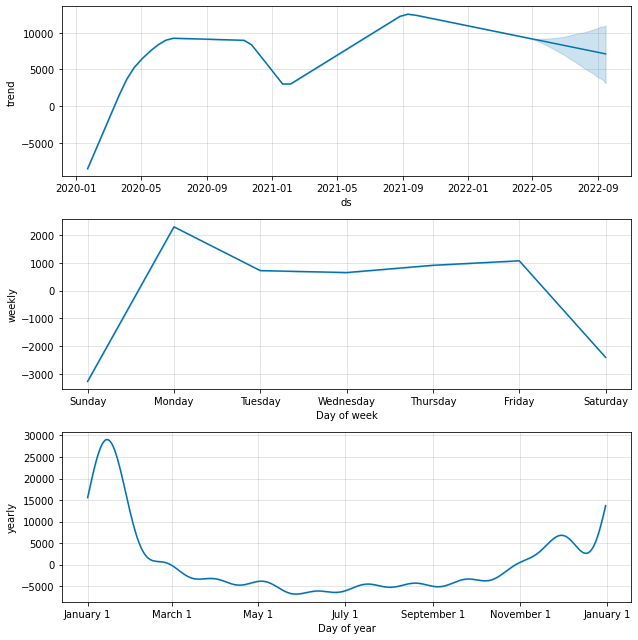

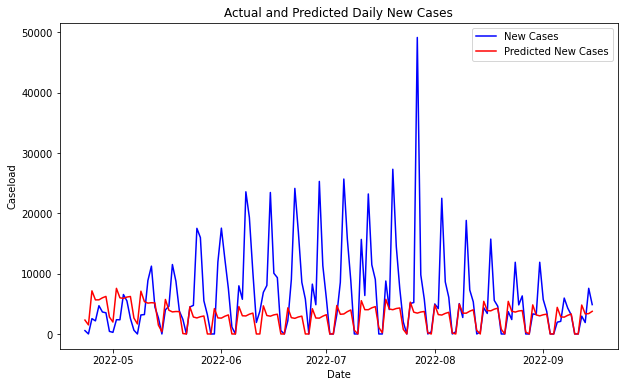

MAE: 4424.283070744495
RMSE: 7803.6485851863745
MSE: 60896931.241081305
MASE: 1.3990676574840415


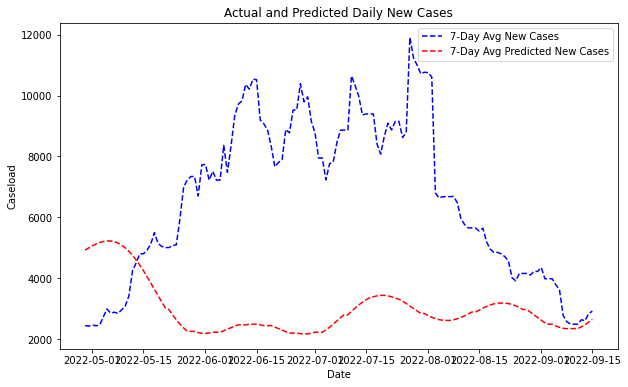

7-Day Avg MAE: 4063.4210516758944
7-Day Avg RMSE: 4770.376357986274
7-Day Avg MSE: 22756490.59683439
7-Day Avg MASE: 12.07881545097536
7-Day Avg MAPE: 0.5627419386576481


In [67]:
model, models, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test, changepoints=[0.089, 0.74, .0014, .00081, 0.0025], seasonalities=[.13, .69, 20.24, 193, .52], n_changepoints_vals=[34, 15, 7, 10, 45])

06:20:11 - cmdstanpy - INFO - Chain [1] start processing
06:20:11 - cmdstanpy - INFO - Chain [1] done processing
06:20:11 - cmdstanpy - INFO - Chain [1] start processing
06:20:11 - cmdstanpy - INFO - Chain [1] done processing
06:20:11 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:12 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:12 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:12 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:12 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0031622776601683794
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

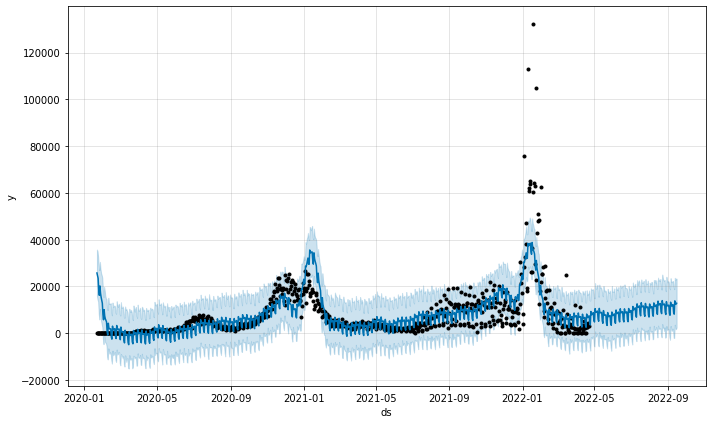

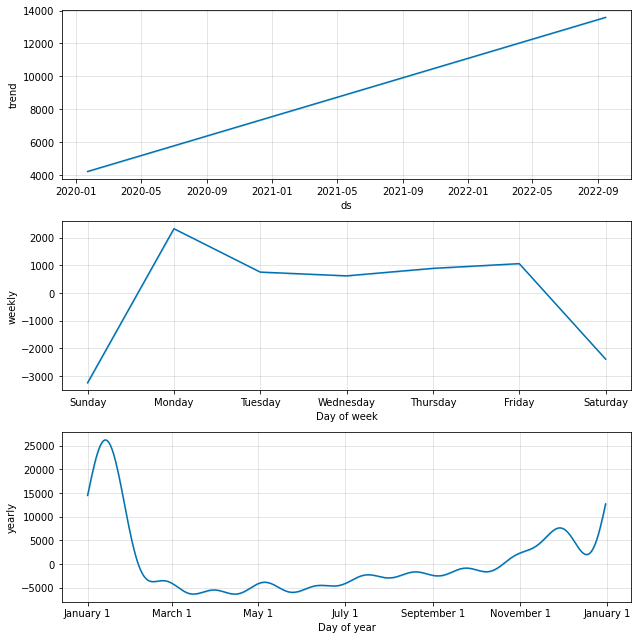

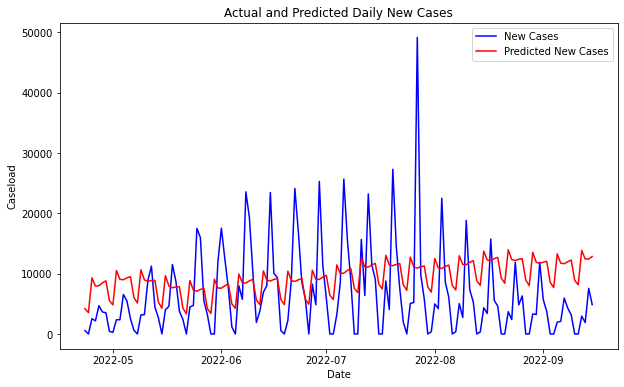

MAE: 6182.917465340329
RMSE: 7596.793512792189
MSE: 57711271.67600149
MASE: 1.955191319436808


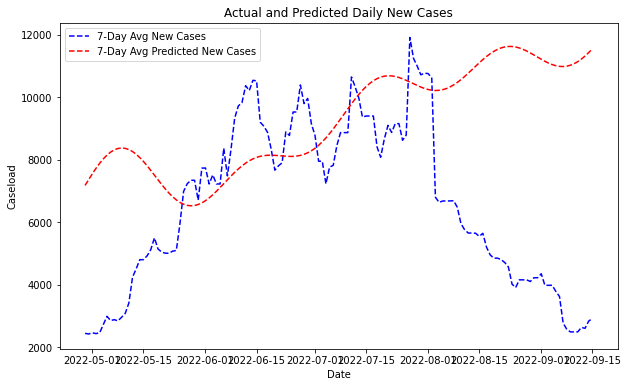

7-Day Avg MAE: 3287.7709172991977
7-Day Avg RMSE: 4257.94921296013
7-Day Avg MSE: 18130131.500147797
7-Day Avg MASE: 9.77313885273155
7-Day Avg MAPE: 0.8055100518281256


In [66]:
model, models, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test)

# NEW ENGLAND

06:22:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:40 - cmdstanpy - INFO - Chain [1] done processing
06:22:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:41 - cmdstanpy - INFO - Chain [1] done processing
06:22:41 - cmdstanpy - INFO - Chain [1] start processing
06:22:41 - cmdstanpy - INFO - Chain [1] done processing
06:22:41 - cmdstanpy - INFO - Chain [1] start processing
06:22:41 - cmdstanpy - INFO - Chain [1] done processing
06:22:42 - cmdstanpy - INFO - Chain [1] start processing
06:22:42 - cmdstanpy - INFO - Chain [1] done processing
06:22:42 - cmdstanpy - INFO - Chain [1] start processing
06:22:42 - cmdstanpy - INFO - Chain [1] done processing
06:22:43 - cmdstanpy - INFO - Chain [1] start processing
06:22:43 - cmdstanpy - INFO - Chain [1] done processing
06:22:43 - cmdstanpy - INFO - Chain [1] start processing
06:22:43 - cmdstanpy - INFO - Chain [1] done processing
06:22:43 - cmdstanpy - INFO - Chain [1] start processing
06:22:43 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.061054022965853265, MASE: 1.0452882712851876
param: 3.1622776601683795, MASE: 1.1718032500614441
param: 0.0736795455966163, MASE: 1.1783903450384297
param: 2.620398528858349, MASE: 1.221699299921195
param: 2.1713743029375174, MASE: 1.2453229132193127


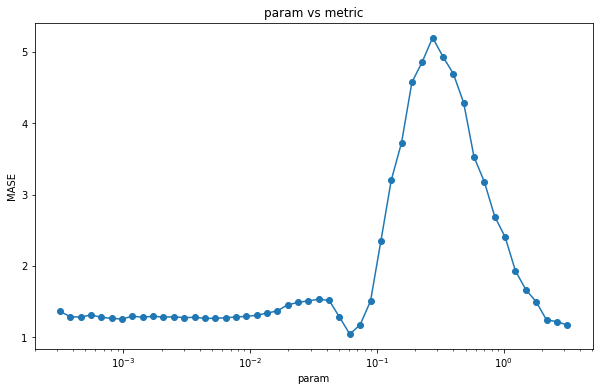

In [68]:
check_hyperparams(ne_train, ne_test)

06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:44 - cmdstanpy - INFO - Chain [1] start processing
06:23:44 - cmdstanpy - INFO - Chain [1] done processing
06:23:44 - cmdstanpy - INFO - Chain [1] start processing
06:23:44 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:46 - cmdstanpy - INFO - Chain [1] start processing
06:23:46 - cmdstanpy - INFO - Chain [1] done processing
06:23:46 - cmdstanpy - INFO - Chain [1] start processing
06:23:46 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 4291.934260128778, MASE: 1.1827788266344146
param: 26.826957952797247, MASE: 1.2183130106940832
param: 790.6043210907702, MASE: 1.2370461650619118
param: 0.9102981779915218, MASE: 1.2993618009933032
param: 5689.866029018293, MASE: 1.3107905508292301


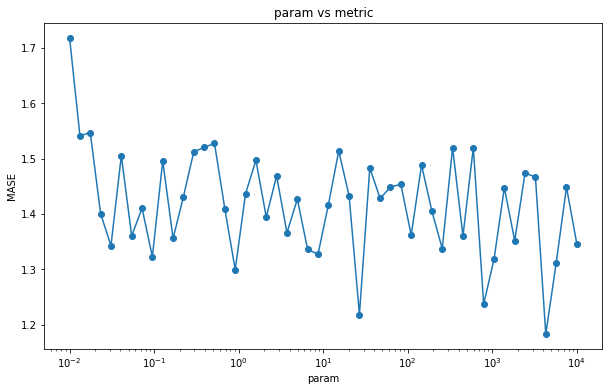

In [69]:
check_hyperparams(ne_train, ne_test, param = 'seasonality_prior_scale')

06:25:39 - cmdstanpy - INFO - Chain [1] start processing
06:25:39 - cmdstanpy - INFO - Chain [1] done processing
06:25:40 - cmdstanpy - INFO - Chain [1] start processing
06:25:40 - cmdstanpy - INFO - Chain [1] done processing
06:25:40 - cmdstanpy - INFO - Chain [1] start processing
06:25:40 - cmdstanpy - INFO - Chain [1] done processing
06:25:41 - cmdstanpy - INFO - Chain [1] start processing
06:25:41 - cmdstanpy - INFO - Chain [1] done processing
06:25:41 - cmdstanpy - INFO - Chain [1] start processing
06:25:41 - cmdstanpy - INFO - Chain [1] done processing
06:25:42 - cmdstanpy - INFO - Chain [1] start processing
06:25:42 - cmdstanpy - INFO - Chain [1] done processing
06:25:42 - cmdstanpy - INFO - Chain [1] start processing
06:25:42 - cmdstanpy - INFO - Chain [1] done processing
06:25:43 - cmdstanpy - INFO - Chain [1] start processing
06:25:43 - cmdstanpy - INFO - Chain [1] done processing
06:25:43 - cmdstanpy - INFO - Chain [1] start processing
06:25:43 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 15.998587196060582, MASE: 1.21741087578247
param: 37.2759372031494, MASE: 1.2464531459153616
param: 44.98432668969444, MASE: 1.2566827679515802
param: 54.286754393238596, MASE: 1.260995549165212
param: 30.888435964774818, MASE: 1.27721193560569


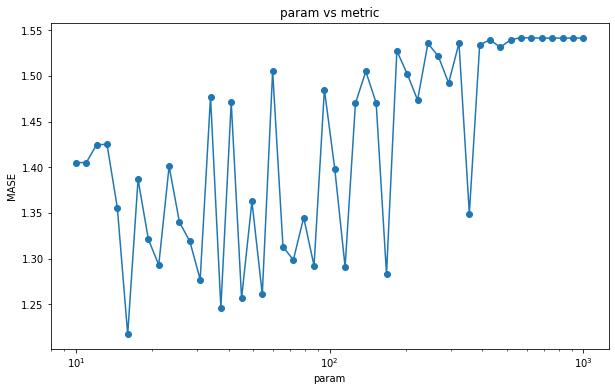

In [73]:
check_hyperparams(ne_train, ne_test, param = 'n_changepoints')

06:27:25 - cmdstanpy - INFO - Chain [1] start processing
06:27:25 - cmdstanpy - INFO - Chain [1] done processing
06:27:25 - cmdstanpy - INFO - Chain [1] start processing
06:27:25 - cmdstanpy - INFO - Chain [1] done processing
06:27:25 - cmdstanpy - INFO - Chain [1] start processing
06:27:26 - cmdstanpy - INFO - Chain [1] done processing
06:27:26 - cmdstanpy - INFO - Chain [1] start processing
06:27:26 - cmdstanpy - INFO - Chain [1] done processing
06:27:26 - cmdstanpy - INFO - Chain [1] start processing
06:27:26 - cmdstanpy - INFO - Chain [1] done processing
06:27:26 - cmdstanpy - INFO - Chain [1] start processing
06:27:26 - cmdstanpy - INFO - Chain [1] done processing
06:27:27 - cmdstanpy - INFO - Chain [1] start processing
06:27:27 - cmdstanpy - INFO - Chain [1] done processing
06:27:27 - cmdstanpy - INFO - Chain [1] start processing
06:27:27 - cmdstanpy - INFO - Chain [1] done processing
06:27:27 - cmdstanpy - INFO - Chain [1] start processing
06:27:27 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.061
seasonality_prior_scale:  5690
n_changepoints:  31


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

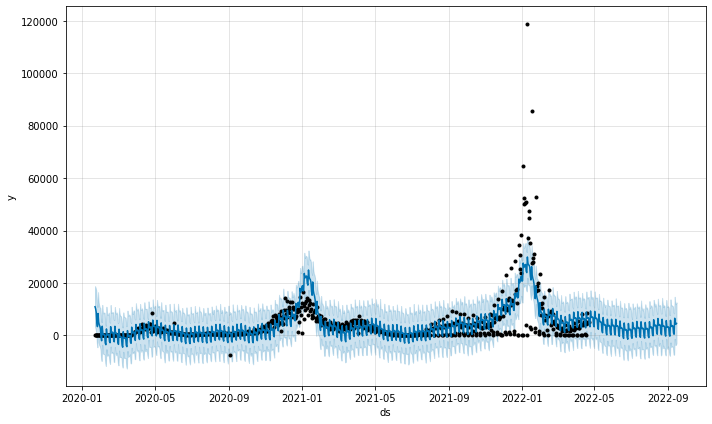

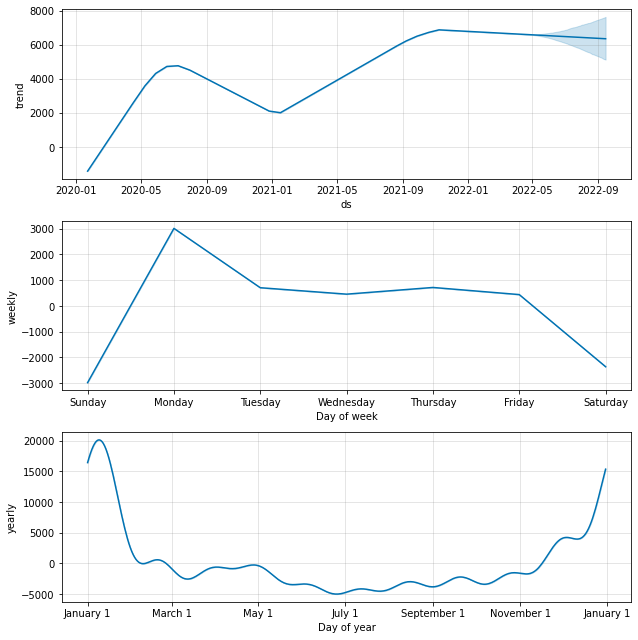

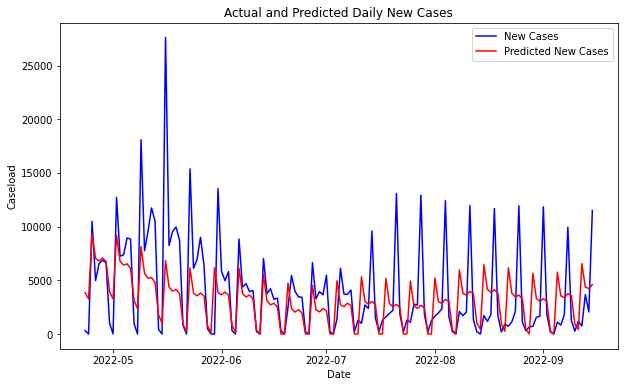

MAE: 2529.1122649659887
RMSE: 3856.389408942631
MSE: 14871739.273404893
MASE: 1.0143580976825108


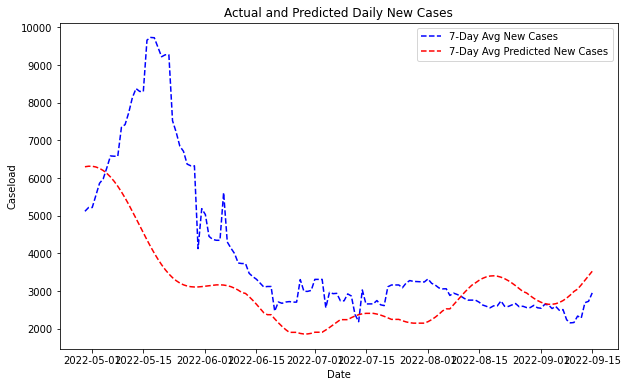

7-Day Avg MAE: 1205.0155797802165
7-Day Avg RMSE: 1797.7732676065573
7-Day Avg MSE: 3231988.721720758
7-Day Avg MASE: 6.351426833563533
7-Day Avg MAPE: 0.2590470288610309


In [74]:
model, models, forecast_mount, fig1, fig2 = search_prophet(ne_train, ne_test, changepoints=[.061, 3.16, .0737, 2.62, 2.17], seasonalities=[4292, 26.8, 790, 0.91, 5690], n_changepoints_vals=[16, 37, 45, 54, 31])

06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

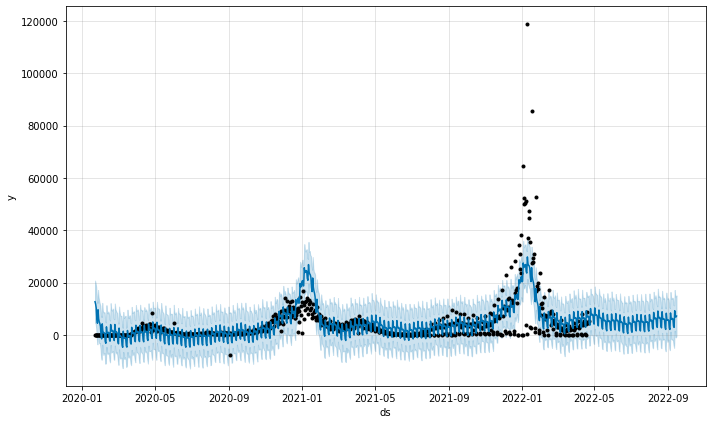

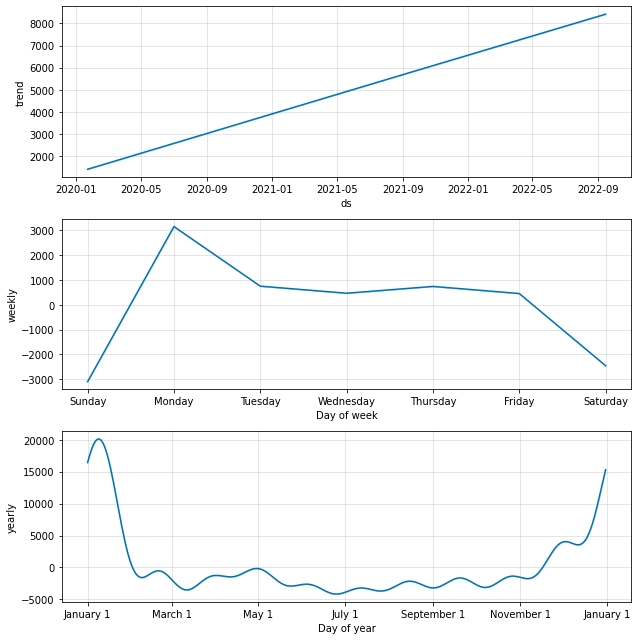

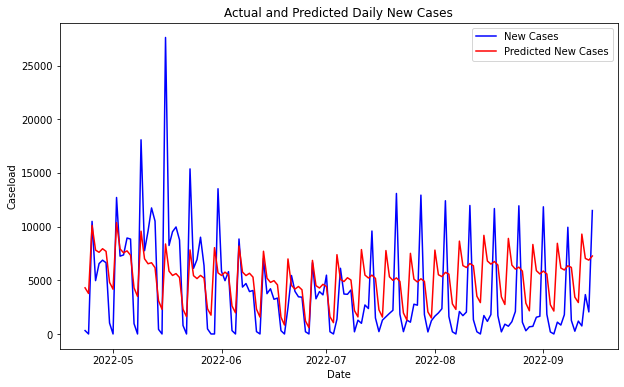

MAE: 3159.5009281776793
RMSE: 4060.253243663281
MSE: 16485656.402678195
MASE: 1.2671898339694845


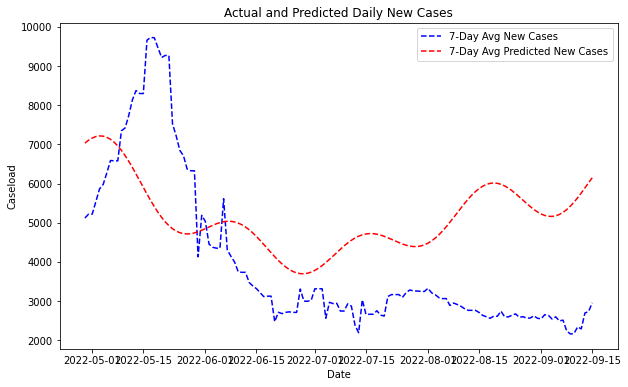

7-Day Avg MAE: 1930.036673727091
7-Day Avg RMSE: 2188.053719891382
7-Day Avg MSE: 4787579.081130516
7-Day Avg MASE: 10.172886496212591
7-Day Avg MAPE: 0.5926185233590976


In [71]:
model, models, forecast_ne, fig1, fig2 = search_prophet(ne_train, ne_test)

# PACIFIC

06:31:26 - cmdstanpy - INFO - Chain [1] start processing
06:31:26 - cmdstanpy - INFO - Chain [1] done processing
06:31:27 - cmdstanpy - INFO - Chain [1] start processing
06:31:27 - cmdstanpy - INFO - Chain [1] done processing
06:31:27 - cmdstanpy - INFO - Chain [1] start processing
06:31:27 - cmdstanpy - INFO - Chain [1] done processing
06:31:28 - cmdstanpy - INFO - Chain [1] start processing
06:31:28 - cmdstanpy - INFO - Chain [1] done processing
06:31:28 - cmdstanpy - INFO - Chain [1] start processing
06:31:28 - cmdstanpy - INFO - Chain [1] done processing
06:31:29 - cmdstanpy - INFO - Chain [1] start processing
06:31:29 - cmdstanpy - INFO - Chain [1] done processing
06:31:29 - cmdstanpy - INFO - Chain [1] start processing
06:31:29 - cmdstanpy - INFO - Chain [1] done processing
06:31:29 - cmdstanpy - INFO - Chain [1] start processing
06:31:29 - cmdstanpy - INFO - Chain [1] done processing
06:31:30 - cmdstanpy - INFO - Chain [1] start processing
06:31:30 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 2.1713743029375174, MASE: 1.9751697230223724
param: 3.1622776601683795, MASE: 2.106613087864075
param: 1.7992936232915515, MASE: 2.2351202053201824
param: 0.08891593339164633, MASE: 2.2907977408874243
param: 2.620398528858349, MASE: 2.375511152470937


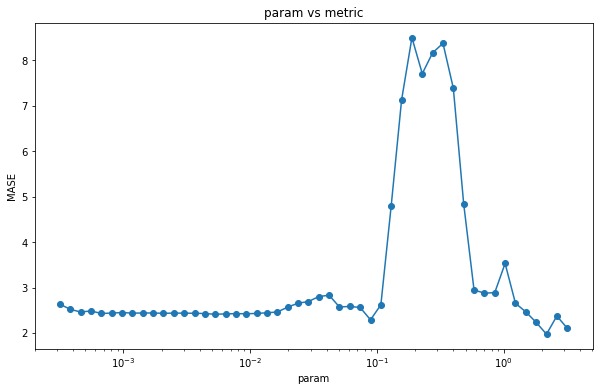

In [75]:
check_hyperparams(pac_train, pac_test)

06:31:55 - cmdstanpy - INFO - Chain [1] start processing
06:31:55 - cmdstanpy - INFO - Chain [1] done processing
06:31:55 - cmdstanpy - INFO - Chain [1] start processing
06:31:55 - cmdstanpy - INFO - Chain [1] done processing
06:31:56 - cmdstanpy - INFO - Chain [1] start processing
06:31:56 - cmdstanpy - INFO - Chain [1] done processing
06:31:56 - cmdstanpy - INFO - Chain [1] start processing
06:31:56 - cmdstanpy - INFO - Chain [1] done processing
06:31:56 - cmdstanpy - INFO - Chain [1] start processing
06:31:56 - cmdstanpy - INFO - Chain [1] done processing
06:31:57 - cmdstanpy - INFO - Chain [1] start processing
06:31:57 - cmdstanpy - INFO - Chain [1] done processing
06:31:57 - cmdstanpy - INFO - Chain [1] start processing
06:31:57 - cmdstanpy - INFO - Chain [1] done processing
06:31:57 - cmdstanpy - INFO - Chain [1] start processing
06:31:58 - cmdstanpy - INFO - Chain [1] done processing
06:31:58 - cmdstanpy - INFO - Chain [1] start processing
06:31:58 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 10000.0, MASE: 2.5357222301508893
param: 0.517947467923121, MASE: 2.5399324266582055
param: 47.14866363457394, MASE: 2.5400301157204197
param: 3.727593720314938, MASE: 2.5541630784913187
param: 0.07196856730011521, MASE: 2.5543654460912646


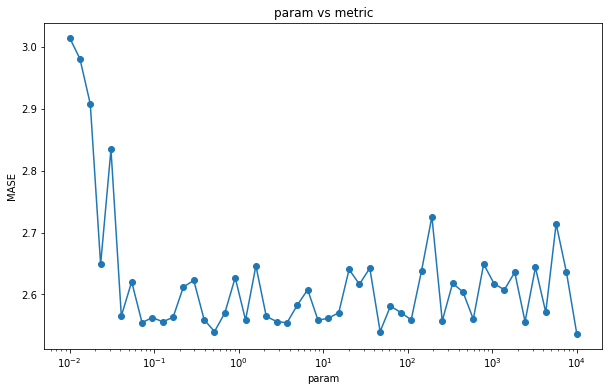

In [76]:
check_hyperparams(pac_train, pac_test, param = 'seasonality_prior_scale')

06:32:14 - cmdstanpy - INFO - Chain [1] start processing
06:32:15 - cmdstanpy - INFO - Chain [1] done processing
06:32:15 - cmdstanpy - INFO - Chain [1] start processing
06:32:15 - cmdstanpy - INFO - Chain [1] done processing
06:32:15 - cmdstanpy - INFO - Chain [1] start processing
06:32:15 - cmdstanpy - INFO - Chain [1] done processing
06:32:16 - cmdstanpy - INFO - Chain [1] start processing
06:32:16 - cmdstanpy - INFO - Chain [1] done processing
06:32:16 - cmdstanpy - INFO - Chain [1] start processing
06:32:16 - cmdstanpy - INFO - Chain [1] done processing
06:32:16 - cmdstanpy - INFO - Chain [1] start processing
06:32:16 - cmdstanpy - INFO - Chain [1] done processing
06:32:17 - cmdstanpy - INFO - Chain [1] start processing
06:32:17 - cmdstanpy - INFO - Chain [1] done processing
06:32:17 - cmdstanpy - INFO - Chain [1] start processing
06:32:17 - cmdstanpy - INFO - Chain [1] done processing
06:32:17 - cmdstanpy - INFO - Chain [1] start processing
06:32:17 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 126.48552168552958, MASE: 2.5577691607766266
param: 10.0, MASE: 2.56138764602613
param: 10.985411419875584, MASE: 2.56138764602613
param: 28.11768697974231, MASE: 2.5620921955790013
param: 167.68329368110065, MASE: 2.564158944999158


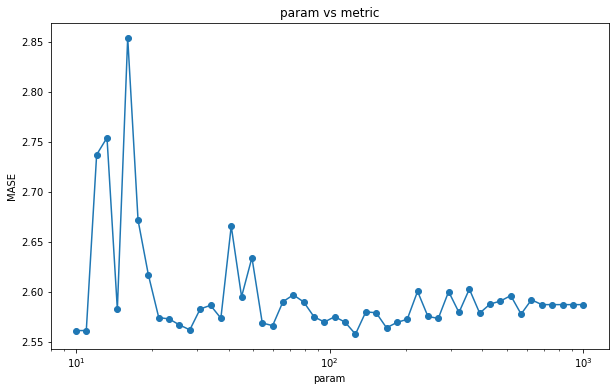

In [77]:
check_hyperparams(pac_train, pac_test, param = 'n_changepoints')

06:33:38 - cmdstanpy - INFO - Chain [1] start processing
06:33:41 - cmdstanpy - INFO - Chain [1] done processing
06:33:41 - cmdstanpy - INFO - Chain [1] start processing
06:33:41 - cmdstanpy - INFO - Chain [1] done processing
06:33:41 - cmdstanpy - INFO - Chain [1] start processing
06:33:42 - cmdstanpy - INFO - Chain [1] done processing
06:33:42 - cmdstanpy - INFO - Chain [1] start processing
06:33:42 - cmdstanpy - INFO - Chain [1] done processing
06:33:42 - cmdstanpy - INFO - Chain [1] start processing
06:33:46 - cmdstanpy - INFO - Chain [1] done processing
06:33:46 - cmdstanpy - INFO - Chain [1] start processing
06:33:49 - cmdstanpy - INFO - Chain [1] done processing
06:33:49 - cmdstanpy - INFO - Chain [1] start processing
06:33:49 - cmdstanpy - INFO - Chain [1] done processing
06:33:49 - cmdstanpy - INFO - Chain [1] start processing
06:33:50 - cmdstanpy - INFO - Chain [1] done processing
06:33:50 - cmdstanpy - INFO - Chain [1] start processing
06:33:51 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0889
seasonality_prior_scale:  3.728
n_changepoints:  168


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

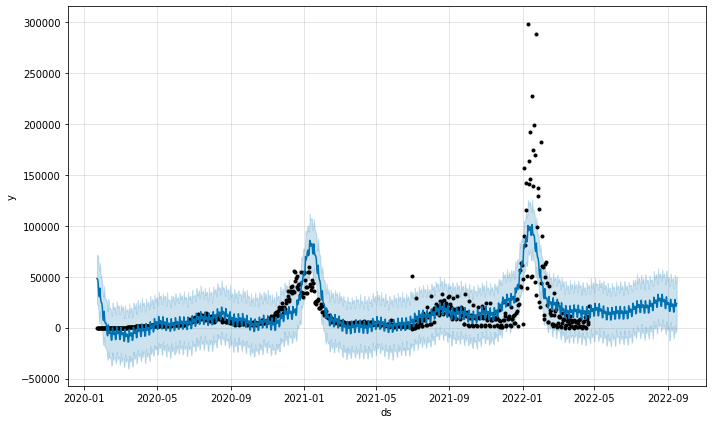

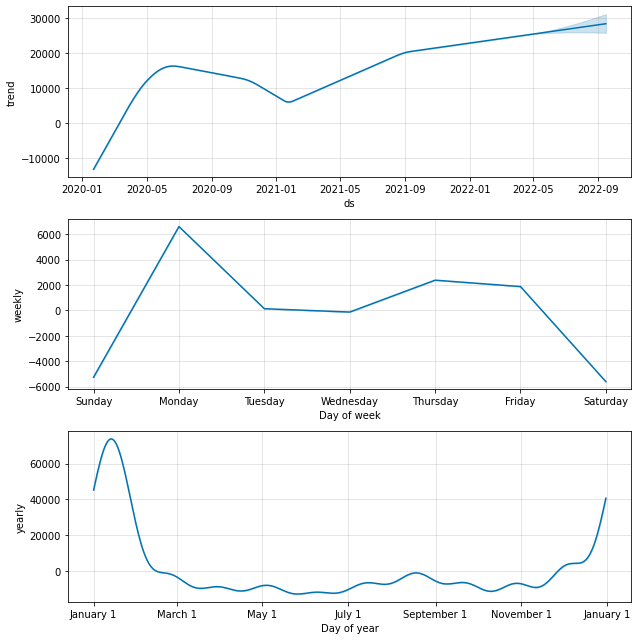

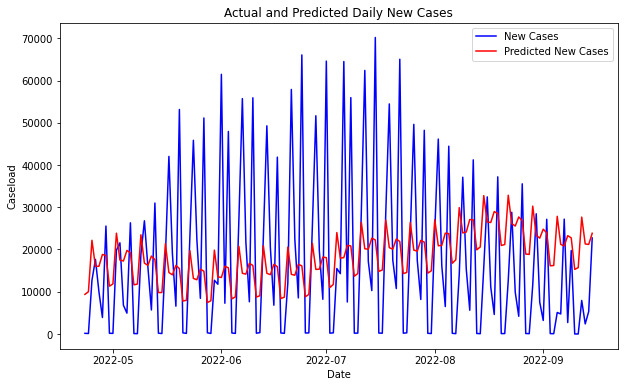

MAE: 14987.273774556405
RMSE: 18906.962798363056
MSE: 357473242.25868464
MASE: 2.243237776171372


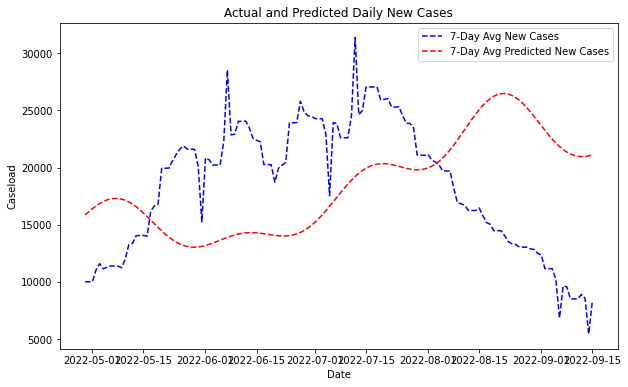

7-Day Avg MAE: 7385.889521841107
7-Day Avg RMSE: 8232.42412771023
7-Day Avg MSE: 67772807.01850553
7-Day Avg MASE: 8.528852934508613
7-Day Avg MAPE: 0.4895667977367191


In [79]:
model, models, forecast_mount, fig1, fig2 = search_prophet(pac_train, pac_test, changepoints=[2.17, 3.16, 1.8, .0889, 2.62], seasonalities=[10000, 47.15, 0.5179, .07197, 3.728], n_changepoints_vals=[126, 10, 11, 28, 168])

06:32:53 - cmdstanpy - INFO - Chain [1] start processing
06:32:53 - cmdstanpy - INFO - Chain [1] done processing
06:32:53 - cmdstanpy - INFO - Chain [1] start processing
06:32:53 - cmdstanpy - INFO - Chain [1] done processing
06:32:53 - cmdstanpy - INFO - Chain [1] start processing
06:32:53 - cmdstanpy - INFO - Chain [1] done processing
06:32:53 - cmdstanpy - INFO - Chain [1] start processing
06:32:53 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing
06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing
06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing
06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing
06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:55 - cmdstanpy - INFO - Chain [1] start processing
06:32:55 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

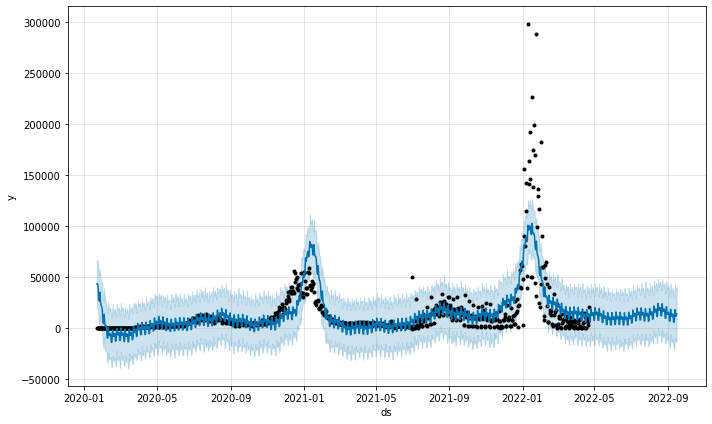

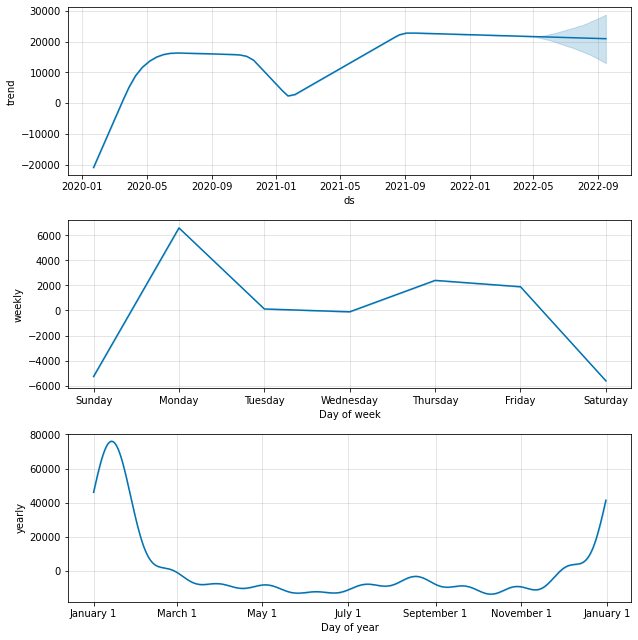

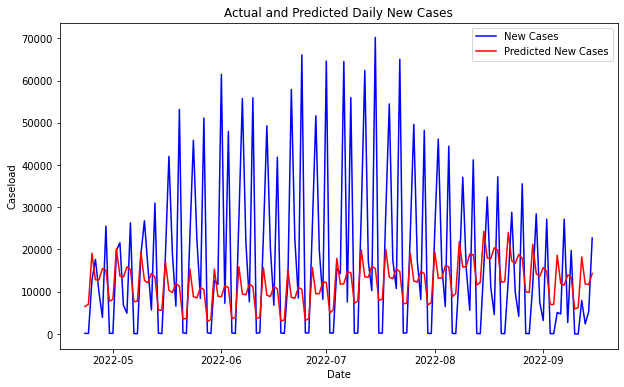

MAE: 13532.762692443697
RMSE: 19384.47196276245
MSE: 375757753.2751235
MASE: 2.0255321244073845


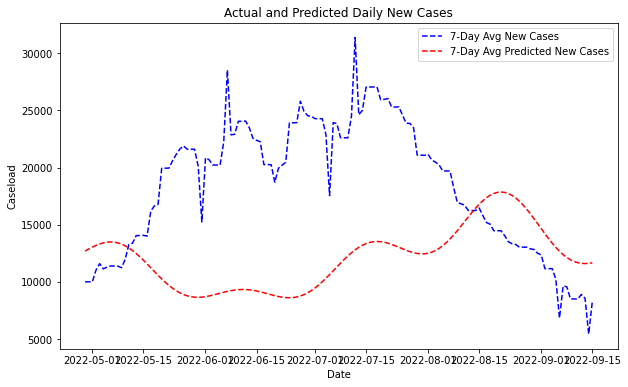

7-Day Avg MAE: 8092.918892006955
7-Day Avg RMSE: 9559.25139904774
7-Day Avg MSE: 91379287.31019618
7-Day Avg MASE: 9.345294813403601
7-Day Avg MAPE: 0.4057280913037905


In [78]:
model, models, forecast_pac, fig1, fig2 = search_prophet(pac_train, pac_test)

# SOUTH ATLANTIC

06:37:02 - cmdstanpy - INFO - Chain [1] start processing
06:37:03 - cmdstanpy - INFO - Chain [1] done processing
06:37:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:37:03 - cmdstanpy - INFO - Chain [1] start processing
06:37:04 - cmdstanpy - INFO - Chain [1] done processing
06:37:05 - cmdstanpy - INFO - Chain [1] start processing
06:37:05 - cmdstanpy - INFO - Chain [1] done processing
06:37:05 - cmdstanpy - INFO - Chain [1] start processing
06:37:05 - cmdstanpy - INFO - Chain [1] done processing
06:37:06 - cmdstanpy - INFO - Chain [1] start processing
06:37:06 - cmdstanpy - INFO - Chain [1] done processing
06:37:06 - cmdstanpy - INFO - Chain [1] start processing
06:37:06 - cmdstanpy - INFO - Chain [1] done processing
06:37:07 - cmdstanpy - INFO - Chain [1] start processing
06:37:07 - cmdstanpy - INFO - Chain [1] done processing
06:37:07 - cmdstanpy - INFO - Chain [1] start process

Lowest 5 MASEs and params:
param: 0.08891593339164633, MASE: 1.4237527049954357
param: 0.0736795455966163, MASE: 1.4826543450219094
param: 2.620398528858349, MASE: 1.537262673030506
param: 0.001422529313485369, MASE: 1.5939305620649322
param: 0.0011787686347935866, MASE: 1.6105698307059668


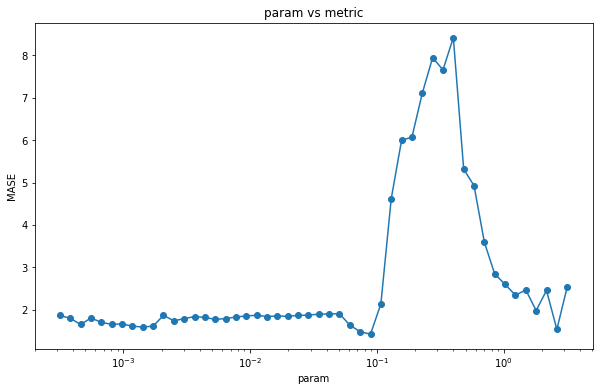

In [80]:
check_hyperparams(satl_train, satl_test)

06:37:31 - cmdstanpy - INFO - Chain [1] start processing
06:37:31 - cmdstanpy - INFO - Chain [1] done processing
06:37:31 - cmdstanpy - INFO - Chain [1] start processing
06:37:31 - cmdstanpy - INFO - Chain [1] done processing
06:37:31 - cmdstanpy - INFO - Chain [1] start processing
06:37:31 - cmdstanpy - INFO - Chain [1] done processing
06:37:32 - cmdstanpy - INFO - Chain [1] start processing
06:37:32 - cmdstanpy - INFO - Chain [1] done processing
06:37:32 - cmdstanpy - INFO - Chain [1] start processing
06:37:32 - cmdstanpy - INFO - Chain [1] done processing
06:37:33 - cmdstanpy - INFO - Chain [1] start processing
06:37:33 - cmdstanpy - INFO - Chain [1] done processing
06:37:33 - cmdstanpy - INFO - Chain [1] start processing
06:37:33 - cmdstanpy - INFO - Chain [1] done processing
06:37:34 - cmdstanpy - INFO - Chain [1] start processing
06:37:34 - cmdstanpy - INFO - Chain [1] done processing
06:37:34 - cmdstanpy - INFO - Chain [1] start processing
06:37:34 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 1048.1131341546852, MASE: 1.8706553670342894
param: 0.22229964825261944, MASE: 1.8716414038395568
param: 5689.866029018293, MASE: 1.8765959575811944
param: 4.941713361323833, MASE: 1.8767083498110941
param: 62.505519252739695, MASE: 1.8839618388882762


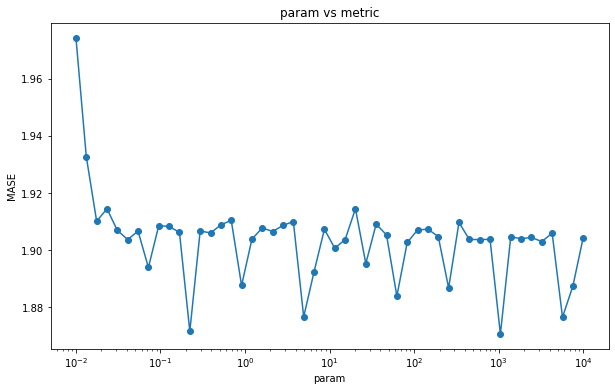

In [81]:
check_hyperparams(satl_train, satl_test, param = 'seasonality_prior_scale')

06:37:51 - cmdstanpy - INFO - Chain [1] start processing
06:37:51 - cmdstanpy - INFO - Chain [1] done processing
06:37:51 - cmdstanpy - INFO - Chain [1] start processing
06:37:51 - cmdstanpy - INFO - Chain [1] done processing
06:37:51 - cmdstanpy - INFO - Chain [1] start processing
06:37:51 - cmdstanpy - INFO - Chain [1] done processing
06:37:52 - cmdstanpy - INFO - Chain [1] start processing
06:37:52 - cmdstanpy - INFO - Chain [1] done processing
06:37:52 - cmdstanpy - INFO - Chain [1] start processing
06:37:52 - cmdstanpy - INFO - Chain [1] done processing
06:37:53 - cmdstanpy - INFO - Chain [1] start processing
06:37:53 - cmdstanpy - INFO - Chain [1] done processing
06:37:53 - cmdstanpy - INFO - Chain [1] start processing
06:37:53 - cmdstanpy - INFO - Chain [1] done processing
06:37:53 - cmdstanpy - INFO - Chain [1] start processing
06:37:53 - cmdstanpy - INFO - Chain [1] done processing
06:37:54 - cmdstanpy - INFO - Chain [1] start processing
06:37:54 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 10.0, MASE: 1.8530155590287392
param: 10.985411419875584, MASE: 1.8530155590287392
param: 17.57510624854792, MASE: 1.8540375358974615
param: 15.998587196060582, MASE: 1.8595648138912388
param: 13.257113655901088, MASE: 1.8645428574334761


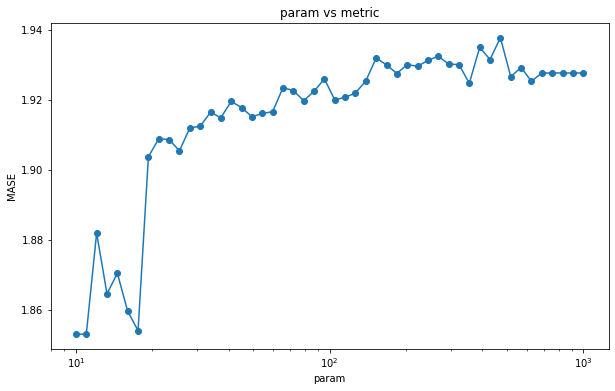

In [82]:
check_hyperparams(satl_train, satl_test, param = 'n_changepoints')

06:41:33 - cmdstanpy - INFO - Chain [1] start processing
06:41:33 - cmdstanpy - INFO - Chain [1] done processing
06:41:33 - cmdstanpy - INFO - Chain [1] start processing
06:41:33 - cmdstanpy - INFO - Chain [1] done processing
06:41:33 - cmdstanpy - INFO - Chain [1] start processing
06:41:34 - cmdstanpy - INFO - Chain [1] done processing
06:41:34 - cmdstanpy - INFO - Chain [1] start processing
06:41:34 - cmdstanpy - INFO - Chain [1] done processing
06:41:34 - cmdstanpy - INFO - Chain [1] start processing
06:41:34 - cmdstanpy - INFO - Chain [1] done processing
06:41:34 - cmdstanpy - INFO - Chain [1] start processing
06:41:35 - cmdstanpy - INFO - Chain [1] done processing
06:41:35 - cmdstanpy - INFO - Chain [1] start processing
06:41:35 - cmdstanpy - INFO - Chain [1] done processing
06:41:35 - cmdstanpy - INFO - Chain [1] start processing
06:41:35 - cmdstanpy - INFO - Chain [1] done processing
06:41:35 - cmdstanpy - INFO - Chain [1] start processing
06:41:35 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0737
seasonality_prior_scale:  62.5
n_changepoints:  13


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

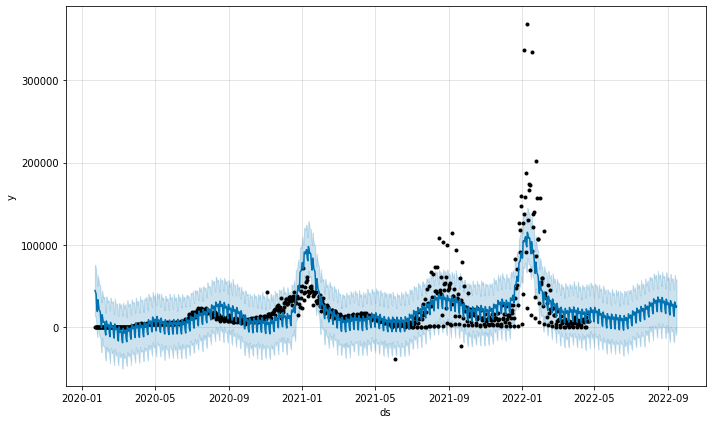

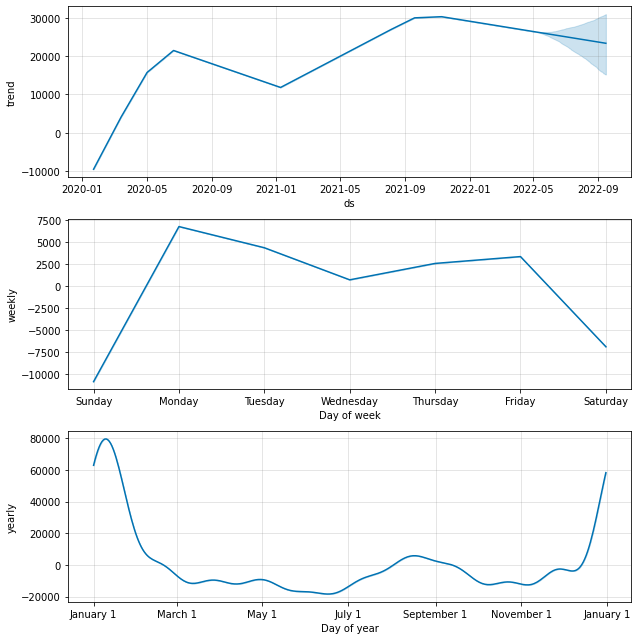

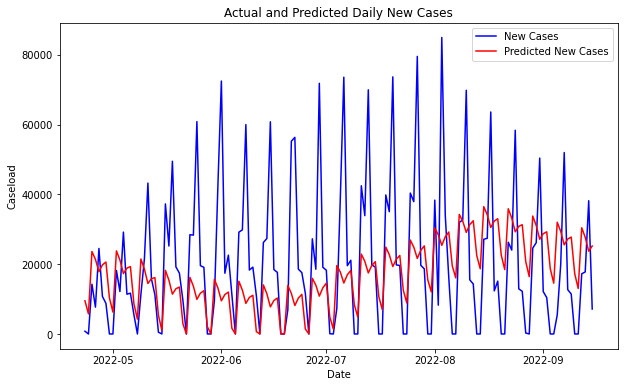

MAE: 14730.460852030179
RMSE: 20458.36112969736
MSE: 418544540.11311185
MASE: 1.4129380484647776


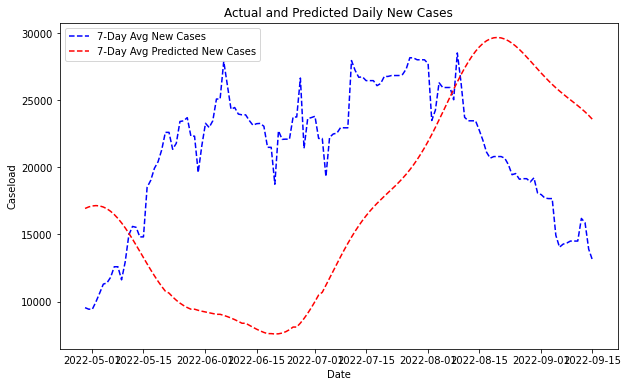

7-Day Avg MAE: 9484.545419899478
7-Day Avg RMSE: 10409.595771054115
7-Day Avg MSE: 108359684.11674774
7-Day Avg MASE: 11.891859001209546
7-Day Avg MAPE: 0.4565976116692389


In [85]:
model, models, forecast_mount, fig1, fig2 = search_prophet(satl_train, satl_test, changepoints=[.0737, .0889, .00142, .00118, 2.62], seasonalities=[1048, .222, 4.94, 5690, 62.5], n_changepoints_vals=[10, 11, 18, 16, 13])

06:38:24 - cmdstanpy - INFO - Chain [1] start processing
06:38:24 - cmdstanpy - INFO - Chain [1] done processing
06:38:24 - cmdstanpy - INFO - Chain [1] start processing
06:38:24 - cmdstanpy - INFO - Chain [1] done processing
06:38:24 - cmdstanpy - INFO - Chain [1] start processing
06:38:24 - cmdstanpy - INFO - Chain [1] done processing
06:38:24 - cmdstanpy - INFO - Chain [1] start processing
06:38:25 - cmdstanpy - INFO - Chain [1] done processing
06:38:25 - cmdstanpy - INFO - Chain [1] start processing
06:38:25 - cmdstanpy - INFO - Chain [1] done processing
06:38:25 - cmdstanpy - INFO - Chain [1] start processing
06:38:25 - cmdstanpy - INFO - Chain [1] done processing
06:38:25 - cmdstanpy - INFO - Chain [1] start processing
06:38:25 - cmdstanpy - INFO - Chain [1] done processing
06:38:25 - cmdstanpy - INFO - Chain [1] start processing
06:38:26 - cmdstanpy - INFO - Chain [1] done processing
06:38:26 - cmdstanpy - INFO - Chain [1] start processing
06:38:26 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

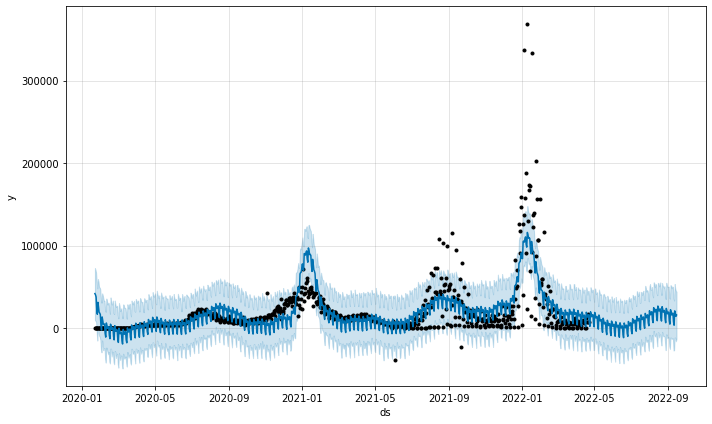

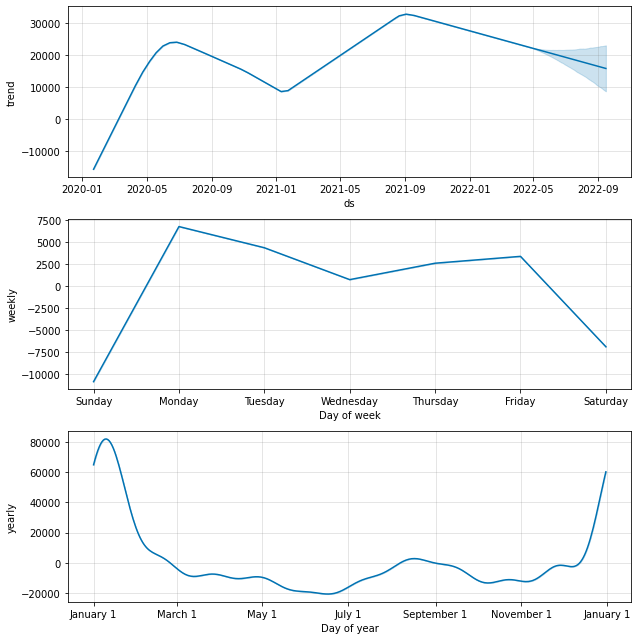

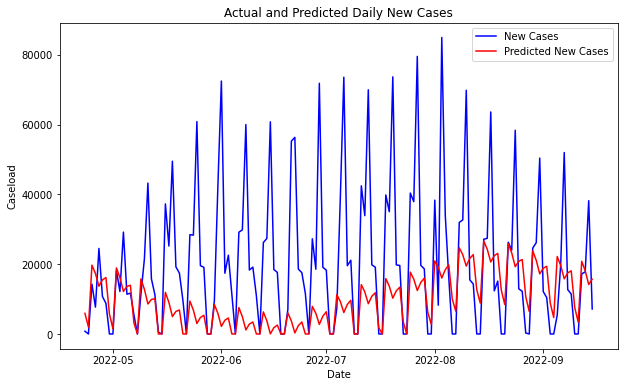

MAE: 14919.118403602311
RMSE: 22986.879949351784
MSE: 528396649.8059111
MASE: 1.431033981472178


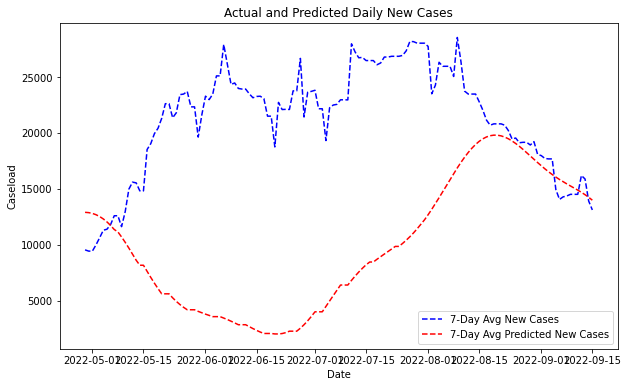

7-Day Avg MAE: 11802.79907568235
7-Day Avg RMSE: 14308.407714078718
7-Day Avg MSE: 204730531.31230736
7-Day Avg MASE: 14.798518665231764
7-Day Avg MAPE: 0.5097084246088899


In [83]:
model, models, forecast_satl, fig1, fig2 = search_prophet(satl_train, satl_test)

# WEST NORTH CENTRAL

06:43:05 - cmdstanpy - INFO - Chain [1] start processing
06:43:05 - cmdstanpy - INFO - Chain [1] done processing
06:43:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:43:05 - cmdstanpy - INFO - Chain [1] start processing
06:43:07 - cmdstanpy - INFO - Chain [1] done processing
06:43:07 - cmdstanpy - INFO - Chain [1] start processing
06:43:07 - cmdstanpy - INFO - Chain [1] done processing
06:43:08 - cmdstanpy - INFO - Chain [1] start processing
06:43:08 - cmdstanpy - INFO - Chain [1] done processing
06:43:08 - cmdstanpy - INFO - Chain [1] start processing
06:43:08 - cmdstanpy - INFO - Chain [1] done processing
06:43:08 - cmdstanpy - INFO - Chain [1] start processing
06:43:08 - cmdstanpy - INFO - Chain [1] done processing
06:43:09 - cmdstanpy - INFO - Chain [1] start processing
06:43:09 - cmdstanpy - INFO - Chain [1] done processing
06:43:09 - cmdstanpy - INFO - Chain [1] start process

Lowest 5 MASEs and params:
param: 0.0736795455966163, MASE: 1.096772720611668
param: 0.0025001103826179307, MASE: 1.130517387131491
param: 0.0020716983998953077, MASE: 1.137649573240458
param: 0.0030171148105292956, MASE: 1.1466041268073843
param: 0.0017166979066078603, MASE: 1.1510689584000957


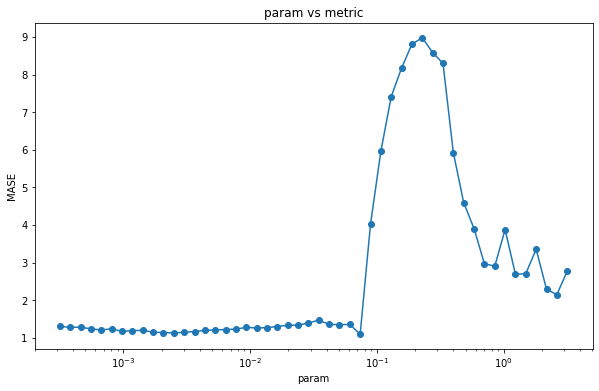

In [86]:
check_hyperparams(wnc_train, wnc_test)

06:43:44 - cmdstanpy - INFO - Chain [1] start processing
06:43:44 - cmdstanpy - INFO - Chain [1] done processing
06:43:45 - cmdstanpy - INFO - Chain [1] start processing
06:43:45 - cmdstanpy - INFO - Chain [1] done processing
06:43:45 - cmdstanpy - INFO - Chain [1] start processing
06:43:45 - cmdstanpy - INFO - Chain [1] done processing
06:43:45 - cmdstanpy - INFO - Chain [1] start processing
06:43:46 - cmdstanpy - INFO - Chain [1] done processing
06:43:46 - cmdstanpy - INFO - Chain [1] start processing
06:43:46 - cmdstanpy - INFO - Chain [1] done processing
06:43:46 - cmdstanpy - INFO - Chain [1] start processing
06:43:46 - cmdstanpy - INFO - Chain [1] done processing
06:43:47 - cmdstanpy - INFO - Chain [1] start processing
06:43:47 - cmdstanpy - INFO - Chain [1] done processing
06:43:47 - cmdstanpy - INFO - Chain [1] start processing
06:43:47 - cmdstanpy - INFO - Chain [1] done processing
06:43:48 - cmdstanpy - INFO - Chain [1] start processing
06:43:48 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 6.551285568595509, MASE: 1.325462738196356
param: 1389.4954943731361, MASE: 1.3296420649785559
param: 1048.1131341546852, MASE: 1.3299080468333846
param: 2.8117686979742307, MASE: 1.330753875654279
param: 4291.934260128778, MASE: 1.3320627299500187


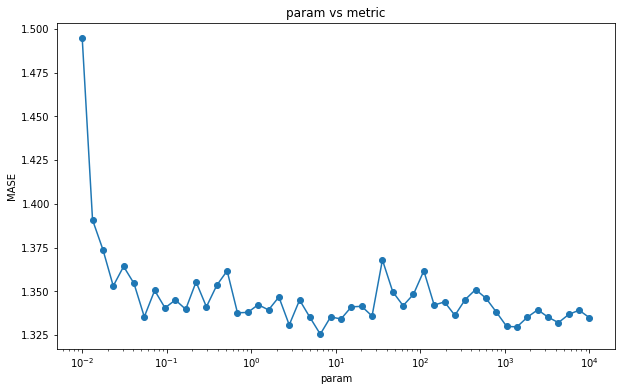

In [87]:
check_hyperparams(wnc_train, wnc_test, param = 'seasonality_prior_scale')

06:44:05 - cmdstanpy - INFO - Chain [1] start processing
06:44:05 - cmdstanpy - INFO - Chain [1] done processing
06:44:06 - cmdstanpy - INFO - Chain [1] start processing
06:44:06 - cmdstanpy - INFO - Chain [1] done processing
06:44:06 - cmdstanpy - INFO - Chain [1] start processing
06:44:06 - cmdstanpy - INFO - Chain [1] done processing
06:44:07 - cmdstanpy - INFO - Chain [1] start processing
06:44:07 - cmdstanpy - INFO - Chain [1] done processing
06:44:07 - cmdstanpy - INFO - Chain [1] start processing
06:44:07 - cmdstanpy - INFO - Chain [1] done processing
06:44:08 - cmdstanpy - INFO - Chain [1] start processing
06:44:08 - cmdstanpy - INFO - Chain [1] done processing
06:44:08 - cmdstanpy - INFO - Chain [1] start processing
06:44:08 - cmdstanpy - INFO - Chain [1] done processing
06:44:08 - cmdstanpy - INFO - Chain [1] start processing
06:44:08 - cmdstanpy - INFO - Chain [1] done processing
06:44:09 - cmdstanpy - INFO - Chain [1] start processing
06:44:09 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 13.257113655901088, MASE: 1.3240400077534737
param: 23.29951810515372, MASE: 1.3274329742166784
param: 19.306977288832496, MASE: 1.3309023714815444
param: 15.998587196060582, MASE: 1.335633152599354
param: 37.2759372031494, MASE: 1.3365092634786098


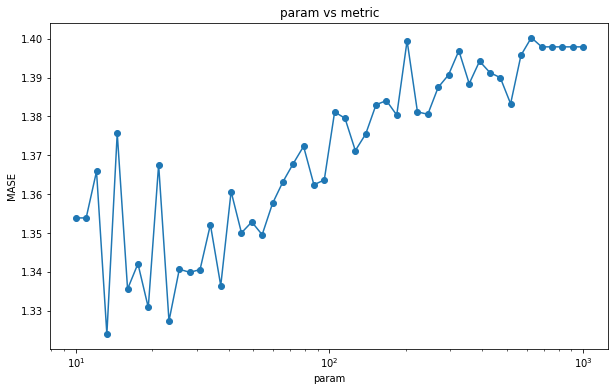

In [88]:
check_hyperparams(wnc_train, wnc_test, param = 'n_changepoints')

06:45:52 - cmdstanpy - INFO - Chain [1] start processing
06:45:52 - cmdstanpy - INFO - Chain [1] done processing
06:45:53 - cmdstanpy - INFO - Chain [1] start processing
06:45:53 - cmdstanpy - INFO - Chain [1] done processing
06:45:53 - cmdstanpy - INFO - Chain [1] start processing
06:45:53 - cmdstanpy - INFO - Chain [1] done processing
06:45:53 - cmdstanpy - INFO - Chain [1] start processing
06:45:53 - cmdstanpy - INFO - Chain [1] done processing
06:45:54 - cmdstanpy - INFO - Chain [1] start processing
06:45:54 - cmdstanpy - INFO - Chain [1] done processing
06:45:54 - cmdstanpy - INFO - Chain [1] start processing
06:45:54 - cmdstanpy - INFO - Chain [1] done processing
06:45:54 - cmdstanpy - INFO - Chain [1] start processing
06:45:54 - cmdstanpy - INFO - Chain [1] done processing
06:45:54 - cmdstanpy - INFO - Chain [1] start processing
06:45:54 - cmdstanpy - INFO - Chain [1] done processing
06:45:55 - cmdstanpy - INFO - Chain [1] start processing
06:45:55 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0737
seasonality_prior_scale:  2.81
n_changepoints:  37


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

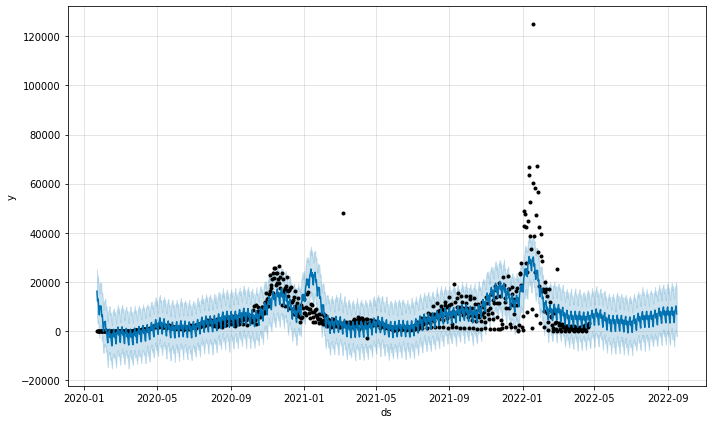

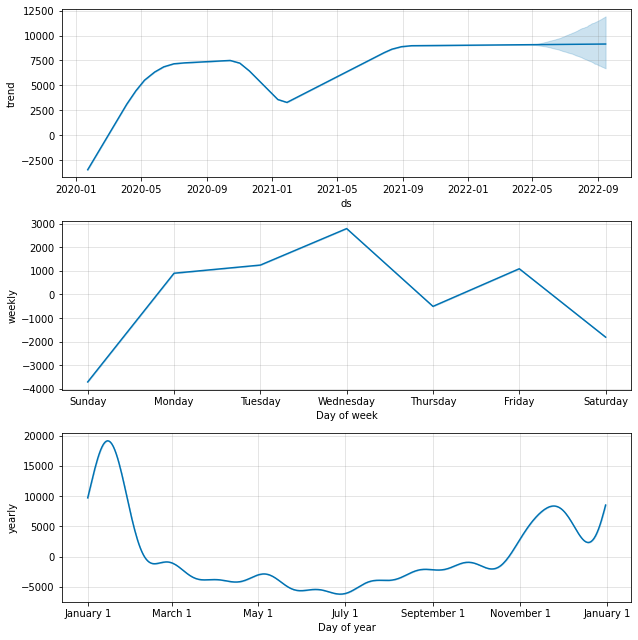

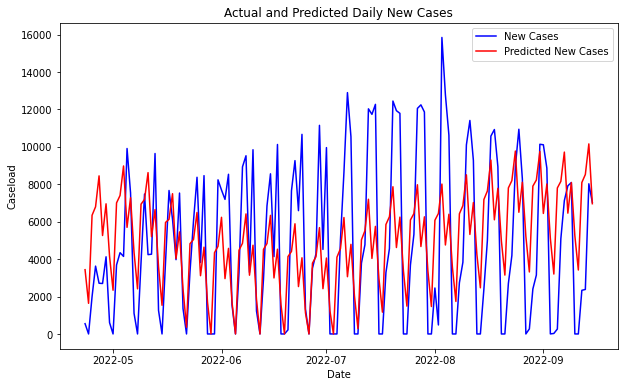

MAE: 2981.4448672202625
RMSE: 3645.8694463266593
MSE: 13292364.01965826
MASE: 0.9527963569138578


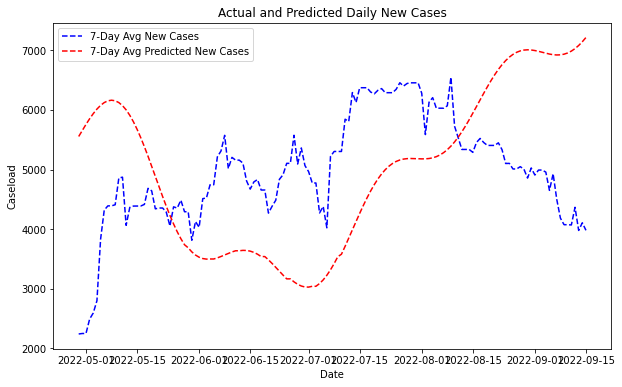

7-Day Avg MAE: 1484.7522701398307
7-Day Avg RMSE: 1673.472870882402
7-Day Avg MSE: 2800511.449579389
7-Day Avg MASE: 8.534988592141893
7-Day Avg MAPE: 0.3238347823307813


In [90]:
model, models, forecast_mount, fig1, fig2 = search_prophet(wnc_train, wnc_test, changepoints=[.0025, .00207, .00302, .00172, .0737], seasonalities=[6.55, 1390, 1048, 2.81, 2.81], n_changepoints_vals=[13, 23, 19, 16, 37])

06:44:40 - cmdstanpy - INFO - Chain [1] start processing
06:44:40 - cmdstanpy - INFO - Chain [1] done processing
06:44:40 - cmdstanpy - INFO - Chain [1] start processing
06:44:40 - cmdstanpy - INFO - Chain [1] done processing
06:44:40 - cmdstanpy - INFO - Chain [1] start processing
06:44:40 - cmdstanpy - INFO - Chain [1] done processing
06:44:40 - cmdstanpy - INFO - Chain [1] start processing
06:44:40 - cmdstanpy - INFO - Chain [1] done processing
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
06:44:41 - cmdstanpy - INFO - Chain [1] done processing
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
06:44:41 - cmdstanpy - INFO - Chain [1] done processing
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
06:44:41 - cmdstanpy - INFO - Chain [1] done processing
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
06:44:41 - cmdstanpy - INFO - Chain [1] done processing
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
06:44:42 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0031622776601683794
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

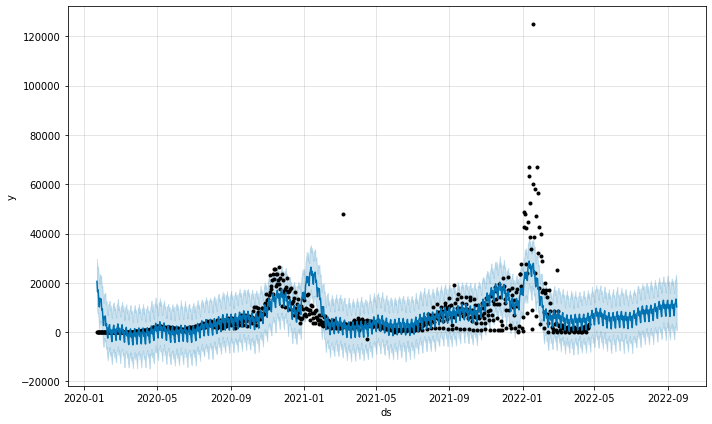

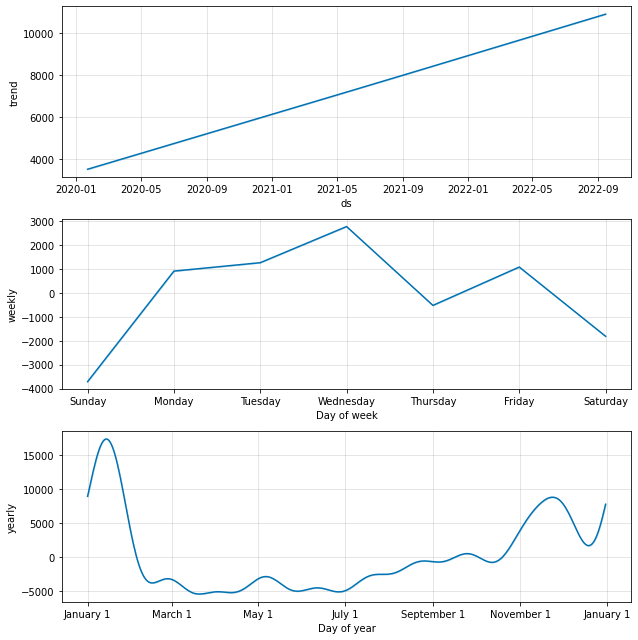

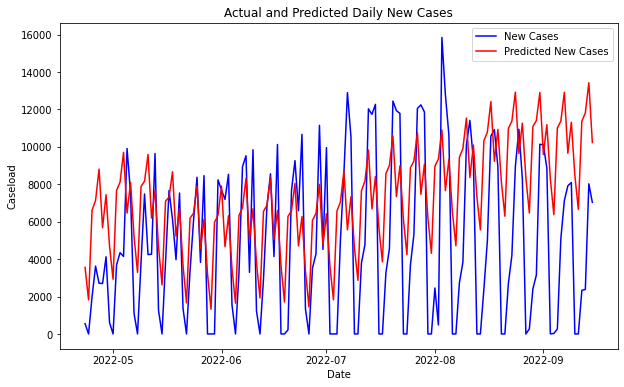

MAE: 3714.2393533278228
RMSE: 4392.727525137147
MSE: 19296055.11009752
MASE: 1.1869794284864048


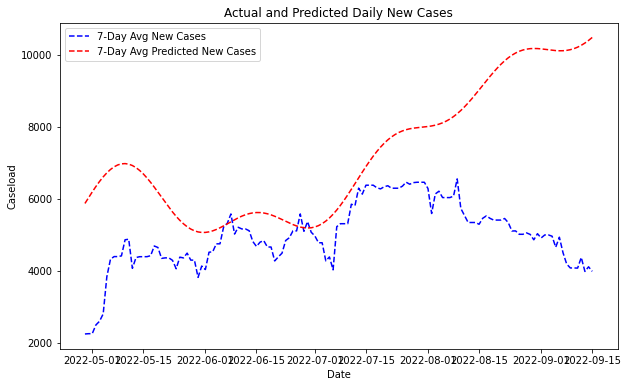

7-Day Avg MAE: 2247.37412015073
7-Day Avg RMSE: 2898.692747066815
7-Day Avg MSE: 8402419.64189776
7-Day Avg MASE: 12.918863882898762
7-Day Avg MAPE: 0.49061457445031725


In [89]:
model, models, forecast_mount, fig1, fig2 = search_prophet(wnc_train, wnc_test)

# WEST SOUTH CENTRAL

06:48:00 - cmdstanpy - INFO - Chain [1] start processing
06:48:00 - cmdstanpy - INFO - Chain [1] done processing
06:48:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:48:00 - cmdstanpy - INFO - Chain [1] start processing
06:48:02 - cmdstanpy - INFO - Chain [1] done processing
06:48:02 - cmdstanpy - INFO - Chain [1] start processing
06:48:02 - cmdstanpy - INFO - Chain [1] done processing
06:48:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:48:02 - cmdstanpy - INFO - Chain [1] start processing
06:48:04 - cmdstanpy - INFO - Chain [1] done processing
06:48:04 - cmdstanpy - INFO - Chain [1] start processing
06:48:04 - cmdstanpy - INFO - Chain [1] done processing
06:48:05 - cmdstanpy - INFO - Chain [1] start processing
06:48:05 - cmdstanpy - INFO - Chain [1] done processing
06:48:05 -

Lowest 5 MASEs and params:
param: 0.0736795455966163, MASE: 1.3705275870238707
param: 0.0020716983998953077, MASE: 1.590889579515436
param: 0.0017166979066078603, MASE: 1.6070396325867302
param: 0.0025001103826179307, MASE: 1.6134972610393927
param: 0.0008094001216083124, MASE: 1.6165366638706946


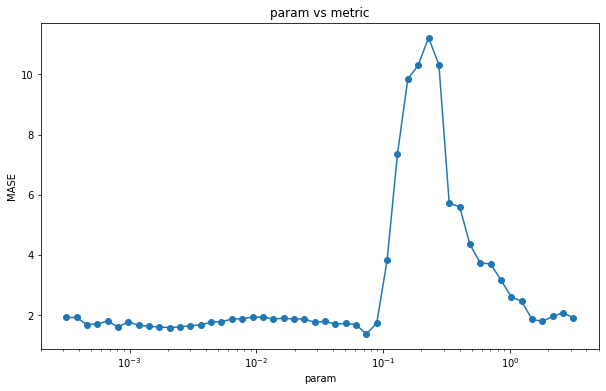

In [92]:
check_hyperparams(wsc_train, wsc_test)

06:48:35 - cmdstanpy - INFO - Chain [1] start processing
06:48:36 - cmdstanpy - INFO - Chain [1] done processing
06:48:36 - cmdstanpy - INFO - Chain [1] start processing
06:48:36 - cmdstanpy - INFO - Chain [1] done processing
06:48:36 - cmdstanpy - INFO - Chain [1] start processing
06:48:37 - cmdstanpy - INFO - Chain [1] done processing
06:48:37 - cmdstanpy - INFO - Chain [1] start processing
06:48:37 - cmdstanpy - INFO - Chain [1] done processing
06:48:37 - cmdstanpy - INFO - Chain [1] start processing
06:48:37 - cmdstanpy - INFO - Chain [1] done processing
06:48:38 - cmdstanpy - INFO - Chain [1] start processing
06:48:38 - cmdstanpy - INFO - Chain [1] done processing
06:48:38 - cmdstanpy - INFO - Chain [1] start processing
06:48:38 - cmdstanpy - INFO - Chain [1] done processing
06:48:39 - cmdstanpy - INFO - Chain [1] start processing
06:48:39 - cmdstanpy - INFO - Chain [1] done processing
06:48:39 - cmdstanpy - INFO - Chain [1] start processing
06:48:40 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 1.5998587196060574, MASE: 1.654191035048958
param: 20.235896477251575, MASE: 1.6739454315335986
param: 1.2067926406393288, MASE: 1.6764997518398002
param: 0.09540954763499938, MASE: 1.6782790198614175
param: 4291.934260128778, MASE: 1.6785642384432096


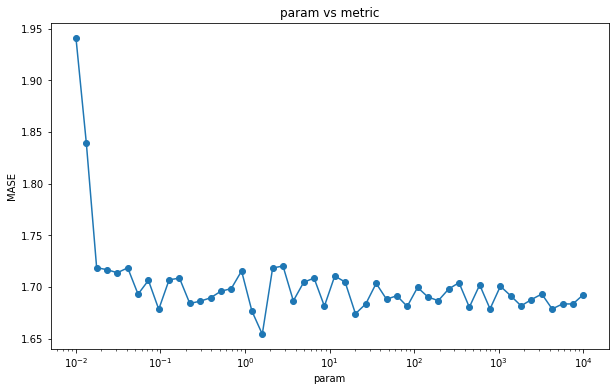

In [93]:
check_hyperparams(wsc_train, wsc_test, param = 'seasonality_prior_scale')

06:48:59 - cmdstanpy - INFO - Chain [1] start processing
06:49:00 - cmdstanpy - INFO - Chain [1] done processing
06:49:00 - cmdstanpy - INFO - Chain [1] start processing
06:49:00 - cmdstanpy - INFO - Chain [1] done processing
06:49:00 - cmdstanpy - INFO - Chain [1] start processing
06:49:00 - cmdstanpy - INFO - Chain [1] done processing
06:49:01 - cmdstanpy - INFO - Chain [1] start processing
06:49:01 - cmdstanpy - INFO - Chain [1] done processing
06:49:01 - cmdstanpy - INFO - Chain [1] start processing
06:49:01 - cmdstanpy - INFO - Chain [1] done processing
06:49:02 - cmdstanpy - INFO - Chain [1] start processing
06:49:02 - cmdstanpy - INFO - Chain [1] done processing
06:49:02 - cmdstanpy - INFO - Chain [1] start processing
06:49:02 - cmdstanpy - INFO - Chain [1] done processing
06:49:03 - cmdstanpy - INFO - Chain [1] start processing
06:49:03 - cmdstanpy - INFO - Chain [1] done processing
06:49:03 - cmdstanpy - INFO - Chain [1] start processing
06:49:03 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 86.85113737513525, MASE: 1.6174095117270764
param: 13.257113655901088, MASE: 1.6743724229529833
param: 40.94915062380423, MASE: 1.6822655266214714
param: 15.998587196060582, MASE: 1.69036293781294
param: 294.705170255181, MASE: 1.691935767063417


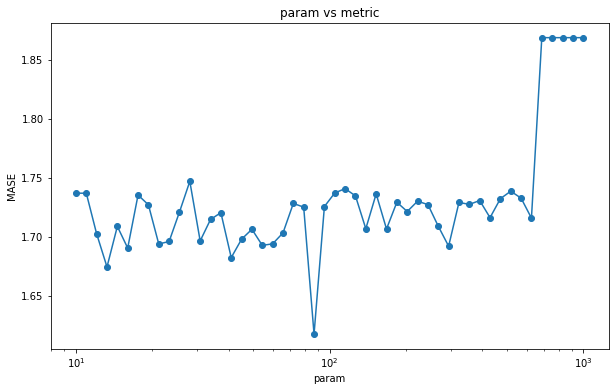

In [94]:
check_hyperparams(wsc_train, wsc_test, param = 'n_changepoints')

06:51:35 - cmdstanpy - INFO - Chain [1] start processing
06:51:35 - cmdstanpy - INFO - Chain [1] done processing
06:51:35 - cmdstanpy - INFO - Chain [1] start processing
06:51:36 - cmdstanpy - INFO - Chain [1] done processing
06:51:36 - cmdstanpy - INFO - Chain [1] start processing
06:51:36 - cmdstanpy - INFO - Chain [1] done processing
06:51:36 - cmdstanpy - INFO - Chain [1] start processing
06:51:36 - cmdstanpy - INFO - Chain [1] done processing
06:51:36 - cmdstanpy - INFO - Chain [1] start processing
06:51:37 - cmdstanpy - INFO - Chain [1] done processing
06:51:37 - cmdstanpy - INFO - Chain [1] start processing
06:51:37 - cmdstanpy - INFO - Chain [1] done processing
06:51:37 - cmdstanpy - INFO - Chain [1] start processing
06:51:37 - cmdstanpy - INFO - Chain [1] done processing
06:51:38 - cmdstanpy - INFO - Chain [1] start processing
06:51:38 - cmdstanpy - INFO - Chain [1] done processing
06:51:38 - cmdstanpy - INFO - Chain [1] start processing
06:51:38 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0737
seasonality_prior_scale:  4290
n_changepoints:  295


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

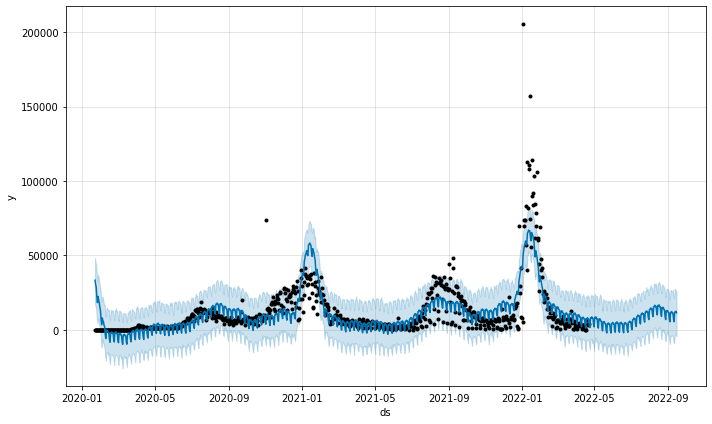

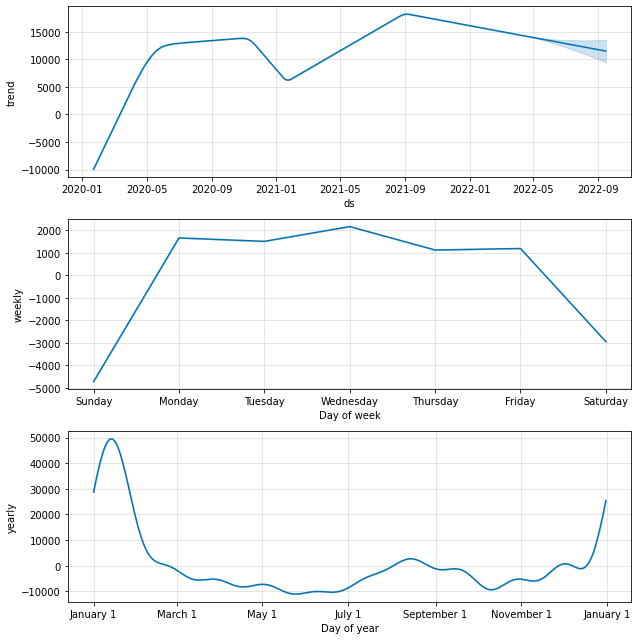

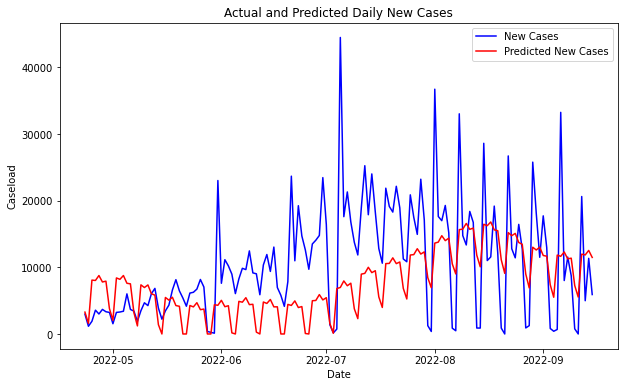

MAE: 6357.513697650229
RMSE: 8248.686471730767
MSE: 68040828.50891416
MASE: 1.4382124032653294


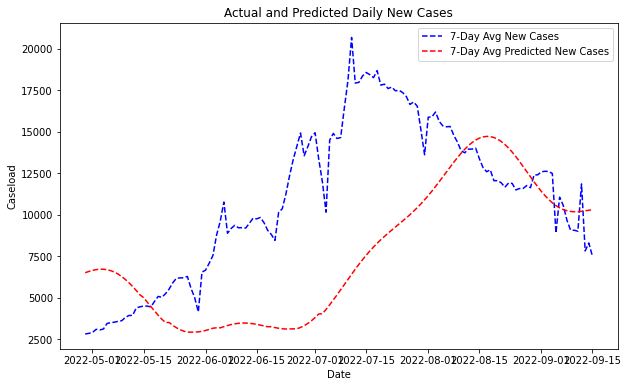

7-Day Avg MAE: 4623.233270647391
7-Day Avg RMSE: 5815.473020959934
7-Day Avg MSE: 33819726.457512856
7-Day Avg MASE: 8.158915235512639
7-Day Avg MAPE: 0.4429158265133301


In [96]:
model, models, forecast_mount, fig1, fig2 = search_prophet(wsc_train, wsc_test, changepoints=[.0737, .00207, .00172, .0025, 1.5, 2], seasonalities=[1.6, 20.2, 1.21, .0954, 4290], n_changepoints_vals=[87, 13, 41, 16, 295])

06:50:13 - cmdstanpy - INFO - Chain [1] start processing
06:50:13 - cmdstanpy - INFO - Chain [1] done processing
06:50:13 - cmdstanpy - INFO - Chain [1] start processing
06:50:14 - cmdstanpy - INFO - Chain [1] done processing
06:50:14 - cmdstanpy - INFO - Chain [1] start processing
06:50:14 - cmdstanpy - INFO - Chain [1] done processing
06:50:14 - cmdstanpy - INFO - Chain [1] start processing
06:50:14 - cmdstanpy - INFO - Chain [1] done processing
06:50:14 - cmdstanpy - INFO - Chain [1] start processing
06:50:14 - cmdstanpy - INFO - Chain [1] done processing
06:50:15 - cmdstanpy - INFO - Chain [1] start processing
06:50:15 - cmdstanpy - INFO - Chain [1] done processing
06:50:15 - cmdstanpy - INFO - Chain [1] start processing
06:50:15 - cmdstanpy - INFO - Chain [1] done processing
06:50:15 - cmdstanpy - INFO - Chain [1] start processing
06:50:15 - cmdstanpy - INFO - Chain [1] done processing
06:50:15 - cmdstanpy - INFO - Chain [1] start processing
06:50:15 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0031622776601683794
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

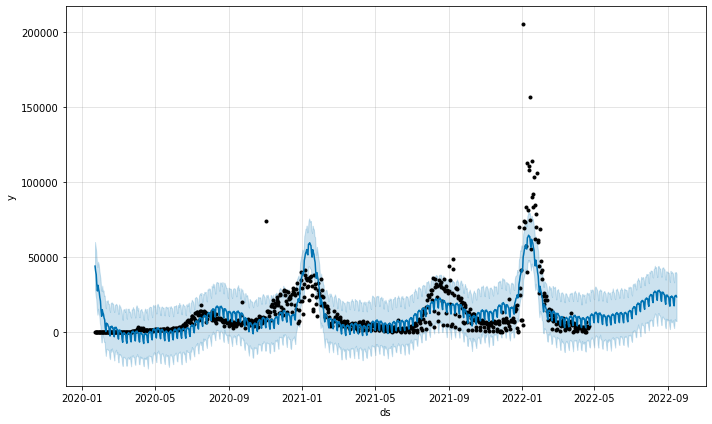

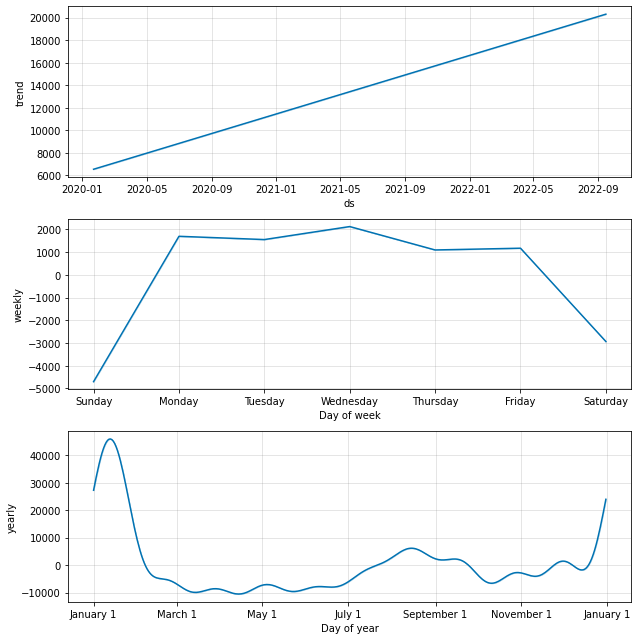

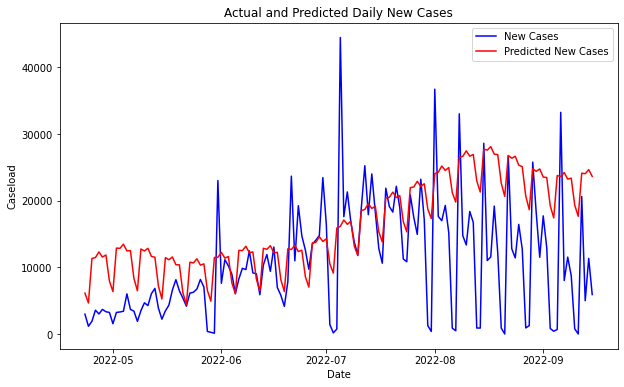

MAE: 7419.941817797236
RMSE: 9700.84770996453
MSE: 94106446.29192407
MASE: 1.6785575087014448


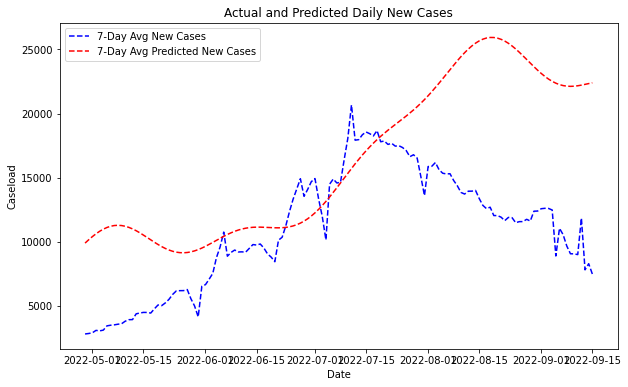

7-Day Avg MAE: 5933.251977269731
7-Day Avg RMSE: 7467.19879531476
7-Day Avg MSE: 55759057.848750204
7-Day Avg MASE: 10.470788973774367
7-Day Avg MAPE: 0.7283786907106069


In [95]:
model, models, forecast_wsc, fig1, fig2 = search_prophet(wsc_train, wsc_test)